# Synthetic Stream Gauges: 
## Improving Streamflow Predictions in Unmonitored River Segments through Deep Learning

This notebook details the development and validation of an advanced Long Short-Term Memory (LSTM) neural network model designed to generate and use synthetic data to improve river streamflow predictions in unmonitored segments. Through the simulation of watershed networks and the application of an innovative LSTM-based approach, this study addresses key challenges in hydrology, such as the lack of monitoring data, and demonstrates how artificial intelligence can significantly contribute to water resource management.

To address data sparsity in unmonitored river segments, we generated a synthetic data set representing various hydrologic conditions. Using "leaky bucket" models to simulate tributary behavior, this approach allows for a detailed and varied representation of possible flow dynamics. The resulting synthetic data are instrumental in training our LSTM model, providing a solid foundation for learning the complexities of river streamflows and improving prediction capabilities.

We developed a balanced in depth and complexity LSTM network to accurately capture the streamflow and overflow dynamics in each of the tributary buckets of the simulated watershed, considering the combined output streamflow as the "ground truth" data.

# 1. Setup

The first thing to do is setup the notebook environment with all the libraries, declare model global parameters, settings, variables and functions that define the leaky bucket model and the bucket networks we want to represent, as well as define the hyperparameters and structure for the deep learning model. 

Note: in a typical full-scale modeling framework, these would be decalared in a configuration file.

### 1.1 Importing libraries 

We import standard libraries for data management, calculations and plotting. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import clear_output
import os
import pickle

We import machine learning libraries for modeling architectures, training, validation and testing.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable 
import sklearn
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange, tqdm
print(torch.__version__)

2.3.1+cu121


We import a library for implementing the unit hydrograph method and set up the default distribution.

In [3]:
from pyflo import system 
from pyflo.nrcs import hydrology

uh484 = system.array_from_csv('distributions/scs484.csv')

In [4]:
# set random seed for reproducibility

np.random.seed(123)

#### 1.1.1 Importing stored data

We import the synthetic data generated for the watershed network, which includes the streamflow data for each of the tributary buckets and the combined output streamflow. Or we can generate the synthetic data on the fly.

In [5]:
# Save data dictionaries
def save_dictionaries(basin_dict, combined_dict, basin_file='data/basin_network_dictionary.pkl', combined_file='data/combined_network_dictionary.pkl'):
    with open(basin_file, 'wb') as f:
        pickle.dump(basin_dict, f)
    with open(combined_file, 'wb') as f:
        pickle.dump(combined_dict, f)

# Load data dictionaries
def load_dictionaries(basin_file='data/basin_network_dictionary.pkl', combined_file='data/combined_network_dictionary.pkl'):
    with open(basin_file, 'rb') as f:
        basin_dict = pickle.load(f)
    with open(combined_file, 'rb') as f:
        combined_dict = pickle.load(f)
    return basin_dict, combined_dict

generate_new_data = False

### 1.2 Defining the physical bucket model system

**Global variables**

Constants in our bucket model system are:
- g, gravitational acceleration [$m/h^2$]
- time step [$h$]

In [6]:
g = 1.271e8
time_step = 1

**Parameters for the Forcing Process (Precipitation)**

To generate precipitation data for our hydrological system, we employ a simple random process that determines whether it is raining based on the previous state, as well as the total amount of rain during the event.

We classify precipitation into three types: None, Light, and Heavy. Each type has distinct ranges of rainfall probabilities and depths.

Precipitation is measured in [$m/h$].

In [7]:
rain_probability_range = {"None": [0.6, 0.7], 
                          "Light": [0.5, 0.8], 
                          "Heavy": [0.2, 0.3]}

threshold_precip = 0.01 # precip value boundary between "light" and "heavy" 
max_precip = 0.25 # max precip possible

# parameters for precip generation
# light precip: Gumbel right
# heavy precip: generalized Pareto
rain_depth_range = {"Light": [0.0008108, 0.0009759], "Heavy": [0.2341, 0.0101, 0.009250]}

**Bucket physical attributes**

The physical leaky bucket attributes include:
- A_bucket, bucket area [$m^2$]
- H_bucket, bucket height [$m$]
- rA_spigot: ratio of diameter of spigot to height of bucket
- rH_spigot: ratio of height of spigot to height of bucket
- K_infiltration, infiltration rate (geological permeability log 10) [$m^{2}$]
- ET_parameter, evapotranspiration parameter [$m/day$]
- soil_depth, affects infiltration [$m$]

We will generate a diversity of leaky buckets by randomy selecting their physical attribute values from the following possible ranges.

In [8]:
bucket_attributes_range = {"A_bucket": [1e4, 2e4],
                           "H_bucket": [0.1, 0.2],
                           "rA_spigot": [0.3, 0.5],
                           "rH_spigot": [0.1, 0.3],
                           "K_infiltration": [-13.8857, 1.1835], # location and scale of normal dist
                           "ET_parameter": [2.2447, 9.9807e-5, 0.0016], # shape, loc, scale of Weibull min dist
                           "soil_depth": [1, 5]
                          }

bucket_attributes_list = list(bucket_attributes_range.keys())
bucket_attributes_list.append('A_spigot')
bucket_attributes_list.append('H_spigot')

**Channel physical parameters**

This section includes the channel physical parameters. Initially, the transformation parameters are defined

- transform_type: 0 (null transform), 1 (simple shift), 2 (time-based displacement), 3 (simple attenuation), 4 (LagK), 5 (Muskingum-Cunge)
- shift_amount: position number to shift (applies when transform_type == 1)
- time_shift: specified number of seconds to move the streamflow
- attenuation_factor: value for multiplying the streamflow
- lag_amount: number of streamflow positions to delay the output
- param_list: list of parameters to apply Muskingum-Cunge transformation


In [9]:
transform_params_range = {"transform_type": [0], #"transform_type": [0, 1, 3, 4, 5], #transform_types 1 to 5 are not completely implemented
                          "shift_amount": [0, 100],
                          # "time_shift": [],
                          "attenuation_factor": [0.01, 0.99],
                          "lag_amount": [0, 100]
                         }

transform_params_list = list(transform_params_range.keys())

**Model input and output variables**

The data fluxes in and out of the leaky bucket considered in this stystem and the leaky bucket state, include
- precipitation into the bucket as a model input (precip) 
- the actual and potential loss to evaporation from the bucket as model inputs (et, pet)
- the water flow over the bucket and out of the spigot as a simulated model output(q_overflow, q_spigot)
- and the state of the water head in the bucket as a simluated model output (h_bucket).

We define lists based on these input and output leaking bucket model variables.

n_input is the number of features to use in the LSTM model. 
n_output is the number of features to predict per each bucket.

In [78]:
n_buckets_per_network = 2
# For individual bucket inputs without combined downstream flow data
input_individual_vars = ['precip', 'A_spigot', 'H_bucket', 'H_spigot']
#input_individual_vars.extend(bucket_attributes_list)
n_indvidual_input = len(input_individual_vars)

# For individual bucket inputs with combined downstream flow data
input_vars = ['precip', 'q_total_output', 'A_spigot', 'H_bucket', 'H_spigot']
#input_vars.extend(bucket_attributes_list)
n_input = len(input_vars) 

# For individual bucket inputs with and without combined downstream flow data
output_vars = [['q_total'] for _ in range(n_buckets_per_network)] 
n_output = len(output_vars[0])

# For combined bucket network inputs with combined downstream flow data
input_combined_vars = [f"{var}_b{bucket}" for bucket in range(n_buckets_per_network) for var in ['precip', 'H_bucket', 'A_spigot', 'H_spigot']]
input_combined_vars.append('q_total_output')
#for attribute in bucket_attributes_list:
    #for bucket in range(n_buckets_per_network):
        #input_combined_vars.append(f"{attribute}_b{bucket}")
output_combined_vars = [f"{var}_b{bucket}" for bucket in range(n_buckets_per_network) for var in ['q_total']]
n_combined_input = len(input_combined_vars)
n_combined_output = len(output_combined_vars)

print("input_individual_vars: " + str(input_individual_vars))
print("n_indvidual_input: " + str(n_indvidual_input))
print("input_vars: " + str(input_vars))
print("n_input: " + str(n_input))
print("output_vars: " + str(output_vars[0]))
print("n_output: " + str(n_output))
print("input_combined_vars: " + str(input_combined_vars))
print("n_combined_input: " + str(n_combined_input))
print("output_combined_vars: " + str(output_combined_vars))
print("n_combined_output: " + str(n_combined_output))


input_individual_vars: ['precip', 'A_spigot', 'H_bucket', 'H_spigot']
n_indvidual_input: 4
input_vars: ['precip', 'q_total_output', 'A_spigot', 'H_bucket', 'H_spigot']
n_input: 5
output_vars: ['q_total']
n_output: 1
input_combined_vars: ['precip_b0', 'H_bucket_b0', 'A_spigot_b0', 'H_spigot_b0', 'precip_b1', 'H_bucket_b1', 'A_spigot_b1', 'H_spigot_b1', 'q_total_output']
n_combined_input: 9
output_combined_vars: ['q_total_b0', 'q_total_b1']
n_combined_output: 2


**Data noise**

Because real world systems are noisy, we can add noise to the synthetic data by multiplying the values by a random factor taken from a normal distribution with a mean of 1 and a standard deviation prescribed for different variables.

In [11]:
print(n_input, n_output, bucket_attributes_list)
is_noise = True
noise = {"pet": 0.1, "et": 0.1, "q": 0.1, "head": 0.1} 

5 3 ['A_bucket', 'H_bucket', 'rA_spigot', 'rH_spigot', 'K_infiltration', 'ET_parameter', 'soil_depth', 'A_spigot', 'H_spigot']


**Illustration of leaking bucket hydrological system**

![Illustration of leaking bucket hydrological system](figs/Leaky_Bucket_Model.png)

### 1.3 Defining the modeling setup 

**Deep Learning Model (LSTM) Hyperparameters**

The hyperparameters for the LSTM (Long Short-Term Memory) deep learning model include:
- device: The device (CPU or CUDA or MPS) used for training and inference.
- hidden_state_size: The number of units in the hidden state of the LSTM model.
- num_layers: Number of LSTM layers.
- num_epochs: Number of training epochs.
- batch_size: Number of samples in each training batch.
- seq_length: Length of input sequences.
- learning_rate: Learning rate for the optimizer.
- num_classes: Number of output classes.
- input_size: Size of the input layer.

These hyperparameters control the behavior and performance of the LSTM model and can be adjusted to optimize the model's accuracy and generalization capabilities for specific tasks and datasets.

In [12]:
# Automatic selection of device: MPS for Apple Silicon, CUDA for NVIDIA GPUs if available, otherwise CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print("Using device: ", device)

# Specific configuration for MPS
if device.type == 'mps':
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
    print("MPS fallback enabled:", os.environ.get('PYTORCH_ENABLE_MPS_FALLBACK'))

# Model parameters
batch_size = 256 
seq_length = 24
dropout_prob = 0.2

## For individual bucket inputs without combined downstream flow data
num_epochs_individual = 20
num_layers_individual = 48
hidden_state_size_individual = 24
learning_rate_individual = np.linspace(start=0.1, stop=0.01, num=num_epochs_individual)

## For combined bucket network inputs with combined downstream flow data
num_epochs_combined = 36
num_layers_combined = 150
hidden_state_size_combined = 100
learning_rate_combined = np.linspace(start=0.1, stop=0.001, num=num_epochs_combined)


Using device:  cuda:0


**Size of data records and splits**

The deep learning framework requires the data to be split into 3 different sets
- Back propogation is done on the training set (train)
- Hyperparameter tuning is done on the validation set (val)
- Calculating model accuracy is done on the testing set (test)

We will define how many randomly generated basin network configurations will be used for the "train", "val" and "test" sets, as well as the length of the simulations for each set.

Additionally it is necessary to define the number of buckets in every basin network (n_bucket_per_network). Consequently, the number of buckets is equal to the number of basin networks multiplied by the number of buckets per network.

In [13]:
#time_splits = {"train": 700, "val": 200, "test": 100}
#time_splits = {"train": 1000, "val": 500,"test": 500}
#time_splits = {"train": 2500, "val": 1000,"test": 1000}
#time_splits = {"train": 3500, "val": 1500,"test": 1500}
#time_splits = {"train": 7000, "val": 2000,"test": 1000}
#time_splits = {"train": 1200, "val": 600,"test": 600}
time_splits = {"train": 7000, "val": 1500,"test": 1500}

#n_basin_networks_split = {"train": 15, "val": 7, "test": 2}
#n_basin_networks_split = {"train": 150, "val": 70, "test": 4}
n_basin_networks_split = {"train": 320, "val": 80, "test": 20}
#n_basin_networks_split = {"train": 700, "val": 200, "test": 100}
#n_basin_networks_split = {"train": 2000, "val": 500, "test": 500}
#n_basin_networks_split = {"train": 350, "val": 204, "test": 204}
n_buckets_split = {"train": n_basin_networks_split["train"] * n_buckets_per_network, "val": n_basin_networks_split["val"] * n_buckets_per_network,"test": n_basin_networks_split["test"] * n_buckets_per_network}

We use the settings above to calculate the total length of the data record to generate and the total number of buckets and basin networks

In [14]:
num_records = time_splits["train"] + time_splits["val"] + time_splits["test"] + seq_length * 3
n_buckets = n_buckets_split["train"] + n_buckets_split["val"] + n_buckets_split["test"]
n_basin_networks = n_basin_networks_split["train"] + n_basin_networks_split["val"] + n_basin_networks_split["test"]
print(n_basin_networks)

420


We then calculate the parameters for the bucket and time splits necessary to feed the model with separate datasets for training, validation, and testing.

We need to create a new function to calculate parameter for the basin network splits into separate datasets.

In [15]:
def split_parameters():
    # create lists of bucket indices for each set based on the given bucket splits
    buckets_for_training = list(range(0, n_buckets_split['train'] + 1))
    buckets_for_val = list(range(n_buckets_split['train'] + 1, 
                                 n_buckets_split['train'] + n_buckets_split['val'] + 1))
    buckets_for_test = list(range(n_buckets - n_buckets_split['test'], n_buckets))

    # determine the time range for each set based on the given time splits
    train_start = seq_length
    train_end   = time_splits["train"]
    val_start   = train_end + seq_length
    val_end     = val_start + time_splits["val"]
    test_start  = val_end + seq_length
    test_end    = test_start + time_splits["test"]
    
    # organize the split parameters into separate lists for each set
    train_split_parameters = [buckets_for_training, train_start, train_end]
    val_split_parameters = [buckets_for_val, val_start, val_end]
    test_split_parameters = [buckets_for_test, test_start, test_end]
    
    return [train_split_parameters, val_split_parameters, test_split_parameters]

In [16]:
[[buckets_for_training, train_start, train_end],
[buckets_for_val, val_start, val_end],
[buckets_for_test, test_start, test_end]]= split_parameters()
print([[buckets_for_training, train_start, train_end],
[buckets_for_val, val_start, val_end],
[buckets_for_test, test_start, test_end]])

[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 22

This function will create separate datasets for training, validation, and testing.

In [17]:
def basin_split_param():
    #create lists of basin indices for each set
    basins_train = list(range(0, n_basin_networks_split['train']))
    basins_val = list(range(n_basin_networks_split['train'], 
                            n_basin_networks_split['train'] + n_basin_networks_split['val']))
    basins_test = list(range(n_basin_networks - n_basin_networks_split['test'], n_basin_networks)) 
    
    #place basin split parameters into separate lists
    train_basin_split_param = [basins_train]
    val_basin_split_param = [basins_val]
    test_basin_split_param = [basins_test]
    
    #determine transform parameters per basin network
    
    
    return [train_basin_split_param, val_basin_split_param, test_basin_split_param]

This will run the function above and print out the range for the whole basin network split

In [18]:
[[basin_networks_train],[basin_networks_val],[basin_networks_test]]= basin_split_param()
print([[basin_networks_train],[basin_networks_val],[basin_networks_test]])

[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 22

### 1.4 Creating a sample of diverse buckets

Now that we know how many buckets we need, we can generate a sample of diverse buckets with their respective boundary and initial conditions by randomly sampling from the possible ranges for each attribute defined in the settings above.

In [19]:
def setup_buckets(n_buckets):
    # Boundary conditions
    buckets = {bucket_attribute:[] for bucket_attribute in bucket_attributes_list}
    buckets['A_spigot'] = []
    buckets['H_spigot'] = []

    for i in range(n_buckets):
        for attribute in bucket_attributes_list:
            if attribute == 'A_bucket' or attribute == 'H_bucket' or attribute == 'rA_spigot' or attribute == 'rH_spigot' or attribute == 'soil_depth':
                buckets[attribute].append(np.random.uniform(bucket_attributes_range[attribute][0],
                                                            bucket_attributes_range[attribute][1]))
            
            if attribute == 'K_infiltration':
                buckets[attribute].append(np.random.normal(bucket_attributes_range[attribute][0],
                                                            bucket_attributes_range[attribute][1]))
                
            if attribute == 'ET_parameter':
                buckets[attribute].append(stats.weibull_min.rvs(bucket_attributes_range[attribute][0],
                                                            bucket_attributes_range[attribute][1],
                                                            bucket_attributes_range[attribute][2]))
                
        buckets['A_spigot'].append(np.pi * (0.5 * buckets['H_bucket'][i] * buckets['rA_spigot'][i]) ** 2)
        buckets['H_spigot'].append(buckets['H_bucket'][i] * buckets['rH_spigot'][i])

    # Initial conditions
    h_water_level = [np.random.uniform(0, buckets['H_bucket'][i]) for i in range(n_buckets)]
    mass_overflow = [0] * n_buckets # set to 0 for simplicity
    return buckets, h_water_level, mass_overflow

In [20]:
buckets, h_water_level, mass_overflow = setup_buckets(n_buckets)

### 1.5 Creating the synthetic "precipitation" 

We first randomly assign rainfall parameters for each bucket, using the probability ranges specified for each precipitation type. We then generate synthetic input time series for each bucket model, known as forcing data. This process involves using the previously defined rainfall parameters and the random process defined in the function below.

In [21]:
def pick_rain_params():
    buck_rain_params = [rain_depth_range,
                        np.random.uniform(rain_probability_range["None"][0],
                                            rain_probability_range["None"][1]),
                        np.random.uniform(rain_probability_range["Heavy"][0],
                                            rain_probability_range["Heavy"][1]),
                        np.random.uniform(rain_probability_range["Light"][0],
                                            rain_probability_range["Light"][1])
                 ]
    return buck_rain_params

In [22]:
def random_rain(preceding_rain, bucket_rain_params):
    depth_range, no_rain_probability, light_rain_probability, heavy_rain_probability = bucket_rain_params
    # some percent of time we have no rain at all
    if np.random.uniform(0.01, 0.99) < no_rain_probability:
        rain = 0

    # When we do have rain, the probability of heavy or light rain depends on the previous hour's rainfall
    else:
        rain = np.inf
        # If last hour was a light rainy hour, or no rain, then we are likely to have light rain this hour
        if preceding_rain < threshold_precip:
            if np.random.uniform(0, 1) < light_rain_probability:
                while rain < 0 or rain > threshold_precip:
                    rain = stats.gumbel_r.rvs(depth_range['Light'][0], depth_range['Light'][1])
            else:
                # But if we do have heavy rain, then it could be very heavy
                while rain < threshold_precip or rain > max_precip:
                    rain = stats.genpareto.rvs(depth_range["Heavy"][0], depth_range["Heavy"][1], depth_range['Heavy'][2])

        # If it was heavy rain last hour, then we might have heavy rain again this hour
        else:
            if np.random.uniform(0, 1) < heavy_rain_probability:
                while rain < threshold_precip or rain > max_precip:
                    rain = stats.genpareto.rvs(depth_range["Heavy"][0], depth_range["Heavy"][1], depth_range['Heavy'][2])
            else:
                while rain < 0 or rain > threshold_precip:
                    rain = stats.gumbel_r.rvs(depth_range['Light'][0], depth_range['Light'][1])
    return rain

We generate a random rainfall input timeseries for each bucket and store it in a dictionary

In [23]:
in_list = {}
for ibuc in range(n_buckets):
    bucket_rain_params = pick_rain_params()
    in_list[ibuc] = [0]
    for i in range(1, num_records):
        in_list[ibuc].append(random_rain(in_list[ibuc][i-1], bucket_rain_params))

### 1.6 Running Numerical Simulations of the Bucket Model to Generate "Ground Truth" Data

We run bucket model simulations to generate the data for our system. 

We perform numerical simulations of a bucket model for a specific bucket index. It iterates over each time step, updating the water level based on precipitation, evapotranspiration, infiltration, overflow, and spigot outflow. The simulation results, including the water level, overflow, spigot flow, and other attributes, are stored in a data frame. This is a concise representation of the bucket model's behavior over time for the given bucket index.

In [24]:
def run_bucket_simulation(ibuc, noise):
    columns = ['precip', 'et', 'infiltration', 'h_bucket', 'q_overflow', 'q_spigot', 'q_total_pre', 'q_total']
    columns.extend(bucket_attributes_list)
    
    # Precompute g (acceleration due to gravity)
    # g = 9.81

    # Pre-generate random numbers for noise
    if is_noise:
        pet_noise = np.random.normal(1, noise['pet'], len(in_list[ibuc]))
        et_noise = np.random.normal(1, noise['et'], len(in_list[ibuc]))
        head_noise = np.random.normal(1, noise['head'], len(in_list[ibuc]))
        q_noise = np.random.uniform(0, noise['q'], len(in_list[ibuc]))

    # Memory to store model results
    data = []

    # Main loop through time
    for t, precip_in in enumerate(in_list[ibuc]):
        # Add the input mass to the bucket
        h_water_level[ibuc] = h_water_level[ibuc] + precip_in

        # Lose mass out of the bucket (evaporation and infiltration)

        # ET (m/s) is the value at each time step taking diurnal fluctuations into account. The definite integral of the following function
        # (excluding noise) from 0 to 24 is equal to ET_parameter, which is measured in m/day.
        et = np.max([0, ((1/7.6394)* buckets["ET_parameter"][ibuc]) * np.sin((np.pi / 12)*t) * np.random.normal(1, noise['pet'])])

        # Calculate change in height due to infiltration using Darcy's Law. Divide Q (m^3/s) by A_bucket (m^2) to get infiltration (m/s)

        k = 10 ** buckets['K_infiltration'][ibuc]
        L = buckets['soil_depth'][ibuc]
        delta_h = h_water_level[ibuc] + L

        infiltration = k * delta_h / L
        
        h_water_level[ibuc] = np.max([0, h_water_level[ibuc] - et])
        h_water_level[ibuc] = np.max([0, h_water_level[ibuc] - infiltration])
        if is_noise:
            h_water_level[ibuc] *= et_noise[t]

        # Overflow if the bucket is too full
        if h_water_level[ibuc] > buckets["H_bucket"][ibuc]:
            mass_overflow[ibuc] = h_water_level[ibuc] - buckets["H_bucket"][ibuc]
            h_water_level[ibuc] = buckets["H_bucket"][ibuc]
            if is_noise:
                h_water_level[ibuc] -= q_noise[t]

        # Calculate head on the spigot
        h_head_over_spigot = h_water_level[ibuc] - buckets["H_spigot"][ibuc]
        if is_noise:
            h_head_over_spigot *= head_noise[t]

        # Calculate water leaving the bucket through the spigot
        if h_head_over_spigot > 0:
            velocity_out = np.sqrt(2 * g * h_head_over_spigot)
            spigot_out_volume = velocity_out * buckets["A_spigot"][ibuc] * time_step

            # prevents spigot from draining below H_spigot
            spigot_out = np.min([spigot_out_volume / buckets['A_bucket'][ibuc], h_head_over_spigot])
            h_water_level[ibuc] -= spigot_out
        else:
            spigot_out = 0

        # Save the data in time series
        data.append([precip_in, et, infiltration, h_water_level[ibuc], mass_overflow[ibuc], spigot_out, mass_overflow[ibuc] + spigot_out, 0] +
                    [buckets[attribute][ibuc] for attribute in bucket_attributes_list])

        mass_overflow[ibuc] = 0

    # set up basin for unit hydrograph transformation
    basin = hydrology.Basin(
        area = buckets['A_bucket'][ibuc] / 4047, # transform sq meters to acres
        cn = 83.0, # "empirical paramter for predicting direct runoff"
        tc = 2.3, # "estimated time of concentration in minutes"
        runoff_dist = uh484, # "unscaled unit hydrograph runoff distribution"
        peak_factor = 1 # "value for scaling peak runoff"
    )

    # set up input array for unit hydrograph transformation
    q_total_inputs = np.zeros(shape=(len(data), 2))
    q_total_untrans_sum = 0

    for i in range(len(data)):
        q_total_untrans_sum += data[i][6] * 39.3701 # transform m to in.
        q_total_inputs[i] = (i, q_total_untrans_sum)

    # transform q_total using unit hydrograph method
    q_total_hyd = basin.flood_hydrograph(q_total_inputs, interval=1)
    q_total = q_total_hyd[:,1]
    q_total_trans_sum = 0

    for i in range(len(data)):
        data[i][7] = q_total[i] / 35.315 / buckets["A_bucket"][ibuc] * 3600 # transform cfs to m^3/hr, normalize q by basin area
        q_total_trans_sum += data[i][7]
    # Convert data to DataFrame
    df = pd.DataFrame(data, columns=columns)
    return df


Then, we run and store the simulations for each bucket in a dictionnary

We ran basin network model simulation to create a dictionary that contains n_basin_networks elements. Each element represents a network of n_buckets_per_network buckets.

In [25]:
def run_basin_network_simultation():
    result = {}
    result['buckets'] = {}
    for i in range(n_basin_networks):
        bucket_dictionary = {}
        for j in range(n_buckets_per_network):
            bucket_dictionary[j] = run_bucket_simulation((i * n_buckets_per_network) + j, noise)
        result['buckets'][i] = bucket_dictionary
    return result

In [26]:
basin_network_dictionary = {}

if generate_new_data or not (os.path.exists('data/basin_network_dictionary.pkl') and os.path.exists('data/combined_network_dictionary.pkl')):
    basin_network_dictionary = run_basin_network_simultation()
else:
    basin_network_dictionary, _ = load_dictionaries()

In [27]:
print(len(basin_network_dictionary))


1


### 1.7 Create a combined streamflow

We create a function to transform streamflow. 

The data in each bucket network and these combined streamflow represent the "ground truth", which is what we will try to learn with the LSTM. 

The transformation type to perform can be one of the following:

- **Null transformation:** Returns the same series of input streamflows
- **Simple shift:** Move the elements right or left according to parameters shift_amount
- **Time-based shift:** Move the elements to the right or left according to the specified number of seconds time_shift; requires some information about the internal time values of the series.
- **Simple Attenuation:** multiply each element of the series by an attenuation factor
- **LagK:** Move each element to position K (lag_amount)
- **Muskingum-Cunge:** Muskingum-Cunge method to combine river flows

In [28]:
#def mcTransform(Q, param_list):
#    return Q

def transformQ(Q, T):
    # Verify if the transformation parameters are null
    if T[0] == 0 or T[0] is None:
        # The null transformation returns the same series of input streamflows
        return Q
    else:
        transform_type = T[0]
        if transform_type == 1:
            # Implement the simple shift transformation
            # Move the elements to the right or left according to parameters
            shift_amount = T[1]
            #print(shift_amount)
            #print(Q[shift_amount:])
            #print(Q[:shift_amount])
            #transformed_Q = Q[shift_amount:] + Q[:shift_amount]
            transformed_Q = np.roll(Q, shift_amount).tolist()
        elif transform_type == 2:
            # Implementing time-based displacement transformation
            # Move the elements to the right or left according to the specified number of seconds
            time_shift = T[1]
            # Information about the internal time values of the series should be used here
            # to calculate the appropriate displacement based on the specified seconds
            # transformed_Q = ...
            # Implement the code for this transformation according to needs and available data
        elif transform_type == 3:
            # Implement the simple attenuation transformation
            # Multiplying each element of the series by an attenuation factor
            attenuation_factor = T[1]
            transformed_Q = [q * attenuation_factor for q in Q]
        elif transform_type == 4:
            # Implement LagK transformation
            # Move each element to position K
            lag_amount = T[1]
            transformed_Q = [Q[i - lag_amount] if i >= lag_amount else 0 for i in range(len(Q))]
        elif transform_type == 5:
            # Implement the Muskingum-Cunge method to combine river flows
            param_list = T[1]
            # transformed_Q = mcTransform(Q, param_list)
            # Implement the code for this transformation according to needs and available data
        #else:
            # In case new transformations are added in the future, they can be handled here
            # by adding more elif blocks
        return transformed_Q


Now we combine the transformed streamflows of a basin network in one single streamflow

In [29]:
def get_param_key(transform_type):
    if transform_type == 0:
        return None
    elif transform_type == 1:
        return "shift_amount"
    #elif transform_type == 2:  # For time-based transformation (not implemented yet)
    #    return "time_shift"
    elif transform_type == 3:
        return "attenuation_factor"
    elif transform_type == 4:
        return "lag_amount"
    #elif tranform_type == 5:  # For Muskingum-Cunge transformation (not implemented yet)
    #    return "param_list"

In [30]:
def generate_transform_params(bucket_basin):
    n = len(bucket_basin)
    transform_params = []
    for i in range(n - 1):
        transform_type = np.random.choice(transform_params_range["transform_type"])
        param_key = get_param_key(transform_type)
        if transform_type == 0:
            param_value = None
        else:
            param_range = transform_params_range[param_key]
            #param_value = None
            if param_key in ["shift_amount", "lag_amount"]:
                param_value = np.random.randint(param_range[0], param_range[1] + 1)
            else:
                param_value = np.random.uniform(param_range[0], param_range[1])
        transform_params.append((transform_type, param_value))
    transform_params.append((0, None))
    return transform_params

In [31]:
def generate_transform_params_network(basin_network_dictionary):
    transform_params_vector = []
    for i in range(n_basin_networks):
        transform_params_vector.append([i, generate_transform_params(basin_network_dictionary['buckets'][i])])
    return transform_params_vector

In [32]:
transform_params_vector = generate_transform_params_network(basin_network_dictionary)

In [33]:
def combine_streamflows(flows, transform_params):
    transformed_flows = []
    
    for Q, T in zip(flows, transform_params):
        transformed_flows.append(transformQ(Q, T))

    return np.sum(transformed_flows, axis=0)

In [34]:

def streamflows_output(transform_params_vector):
    combined_streamflows_dictionary = {} 
    q_total_matrix = []
    for i in range(n_basin_networks):
        q_total_vector = []
        for j in range(n_buckets_per_network):
            q_total_vector.append(basin_network_dictionary['buckets'][i][j]['q_total'])
        q_total_matrix.append(combine_streamflows(q_total_vector, transform_params_vector[i][1]))
    combined_streamflows_dictionary['q_total_output'] = q_total_matrix
    return combined_streamflows_dictionary


In [35]:
combined_streamflows_dictionary = streamflows_output(transform_params_vector)

In [36]:
print(len(combined_streamflows_dictionary['q_total_output']))

420


In [37]:
for inetwork in range(n_basin_networks):
    q_total_output_values = combined_streamflows_dictionary['q_total_output'][inetwork]
    
    for ibuc in range(n_buckets_per_network):
        bucket_df = basin_network_dictionary['buckets'][inetwork][ibuc]
        bucket_df['q_total_output'] = q_total_output_values


In [38]:
print(basin_network_dictionary['buckets'][0][0].keys())
print(basin_network_dictionary)

Index(['precip', 'et', 'infiltration', 'h_bucket', 'q_overflow', 'q_spigot',
       'q_total_pre', 'q_total', 'A_bucket', 'H_bucket', 'rA_spigot',
       'rH_spigot', 'K_infiltration', 'ET_parameter', 'soil_depth', 'A_spigot',
       'H_spigot', 'q_total_output'],
      dtype='object')
{'buckets': {0: {0:          precip            et  infiltration  h_bucket  q_overflow  q_spigot  \
0      0.000000  0.000000e+00  2.757973e-15  0.104615    0.000000  0.000404   
1      0.020912  9.801527e-05  2.778858e-15  0.075747    0.002295  0.000290   
2      0.000000  2.182789e-04  2.743065e-15  0.073242    0.000000  0.000314   
3      0.001851  3.048948e-04  2.742596e-15  0.064842    0.000000  0.000282   
4      0.025962  3.568801e-04  2.753892e-15  0.088348    0.000000  0.000367   
...         ...           ...           ...       ...         ...       ...   
10067  0.000000  8.924127e-05  2.751008e-15  0.083751    0.000000  0.000341   
10068  0.000000  1.171008e-16  2.748820e-15  0.072172    0.00

In [39]:
# Create combined network dictionary
combined_network_dictionary = {'networks': {}}

if generate_new_data or not (os.path.exists('data/basin_network_dictionary.pkl') and os.path.exists('data/combined_network_dictionary.pkl')):

    for network_id in basin_network_dictionary['buckets'].keys():
        combined_df_list = [] 
        q_total_output_series = None  

        for bucket_id in range(n_buckets_per_network):
            df = basin_network_dictionary['buckets'][network_id][bucket_id]
            if q_total_output_series is None:
                q_total_output_series = df['q_total_output']
            df = df.rename(columns={col: f"{col}_b{bucket_id}" for col in df.columns if col != 'q_total_output'})
            df = df.drop(columns=['q_total_output'])
            combined_df_list.append(df)

        combined_df = pd.concat(combined_df_list, axis=1)
        combined_df['q_total_output'] = q_total_output_series
        combined_network_dictionary['networks'][network_id] = combined_df
else:
    _, combined_network_dictionary = load_dictionaries()

In [40]:
if generate_new_data or not (os.path.exists('data/basin_network_dictionary.pkl') and os.path.exists('data/combined_network_dictionary.pkl')):
    save_dictionaries(basin_network_dictionary, combined_network_dictionary)


In [41]:
print(combined_network_dictionary['networks'][0].keys())
print(combined_network_dictionary)

Index(['precip_b0', 'et_b0', 'infiltration_b0', 'h_bucket_b0', 'q_overflow_b0',
       'q_spigot_b0', 'q_total_pre_b0', 'q_total_b0', 'A_bucket_b0',
       'H_bucket_b0', 'rA_spigot_b0', 'rH_spigot_b0', 'K_infiltration_b0',
       'ET_parameter_b0', 'soil_depth_b0', 'A_spigot_b0', 'H_spigot_b0',
       'precip_b1', 'et_b1', 'infiltration_b1', 'h_bucket_b1', 'q_overflow_b1',
       'q_spigot_b1', 'q_total_pre_b1', 'q_total_b1', 'A_bucket_b1',
       'H_bucket_b1', 'rA_spigot_b1', 'rH_spigot_b1', 'K_infiltration_b1',
       'ET_parameter_b1', 'soil_depth_b1', 'A_spigot_b1', 'H_spigot_b1',
       'q_total_output'],
      dtype='object')
{'networks': {0:        precip_b0         et_b0  infiltration_b0  h_bucket_b0  q_overflow_b0  \
0       0.000000  0.000000e+00     2.757973e-15     0.104615       0.000000   
1       0.020912  9.801527e-05     2.778858e-15     0.075747       0.002295   
2       0.000000  2.182789e-04     2.743065e-15     0.073242       0.000000   
3       0.001851  3.04894

This function retrieves data from a specific bucket within a given basin network. It takes three arguments:
- **inetwork**: The index of the watershed network from which data will be retrieved.
- **ibuc**: The index of the specific bucket within the basin network.
- **basin_network_dictionary**: A dictionary containing all the basin networks and their respective buckets.

The function returns a DataFrame **df** containing the data of the specified bucket.

In [42]:
def retrieve_data(inetwork, ibuc, basin_network_dictionary):
    df = basin_network_dictionary['buckets'][inetwork][ibuc]
    return df

def retrieve_combined_data(inetwork, combined_network_dictionary):
    df = combined_network_dictionary['networks'][inetwork]
    return df

### 1.8 Visualizing a sample of the bucket fluxes
We plot the model simulations to ensure the existence of fluxes and validate that the generated values are realistics for both the spigot (channel flow) and over the top (flooding). 

In [43]:
'''def viz_simulation(basin_network_dictionary, inetwork, ibuc):
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    print('Bucket:', ibuc)
    print("Overflow mean:", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].q_overflow.mean(),2))
    print("Overflow max:", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].q_overflow.max(),2))

    input_vars_for_plot = [var for var in input_vars if var != 'q_total_output']
    
    basin_network_dictionary['buckets'][inetwork][ibuc].loc[:100, input_vars_for_plot].plot(ax=ax1)
    basin_network_dictionary['buckets'][inetwork][ibuc].loc[:100, ['q_overflow', 'q_spigot','h_bucket']].plot(ax=ax2)

    ax1.set_title('Model inputs')
    ax2.set_title('Model outputs')
    plt.legend()
    plt.show()
    plt.close()'''

def viz_simulation(basin_network_dictionary, inetwork, ibuc):
    fig = plt.figure(figsize=(20, 3))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    print('Bucket:', ibuc)
    print("Overflow mean (m/h):", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].q_overflow.mean(),2))
    print("Overflow max (m/h):", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].q_overflow.max(),2))
    print("Bucket area (m^2): ", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].A_bucket[0],2))
    print("Spigot area (m^2): ", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].A_spigot[0],4))
    print("Bucket height (m): ", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].H_bucket[0],2))
    print("Spigot height (m): ", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].H_spigot[0],3))
    print("Geologic permeability (m^2): 1e", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].K_infiltration[0],2))
    print("ET (m/day): ", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].ET_parameter[0],4))
    print("Soil depth (m): ", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].soil_depth[0],2))

    basin_network_dictionary['buckets'][inetwork][ibuc].loc[:100,['precip', 'et', 'infiltration']].plot(ax=ax1)
    basin_network_dictionary['buckets'][inetwork][ibuc].loc[:100,['q_overflow', 'q_spigot', 'q_total_pre', 'q_total']].plot(ax=ax2)
    basin_network_dictionary['buckets'][inetwork][ibuc].loc[:100,["h_bucket"]].plot(ax=ax3)
    ax1.set_title('Model inputs')
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Inputs (m)')
    ax2.set_title('Model outputs')
    ax2.set_xlabel('Time (h)')
    ax2.set_ylabel('Yield (m)')
    ax3.set_title('h_bucket')
    ax3.set_xlabel('Time (h)')
    ax3.set_ylabel('Height of water in bucket (m)')
    plt.legend()
    plt.show()
    plt.close()

Bucket: 0
Overflow mean (m/h): 0.0
Overflow max (m/h): 0.19
Bucket area (m^2):  12488.28
Spigot area (m^2):  0.0019
Bucket height (m):  0.11
Spigot height (m):  0.027
Geologic permeability (m^2): 1e -12.53
ET (m/day):  0.0014
Soil depth (m):  1.47


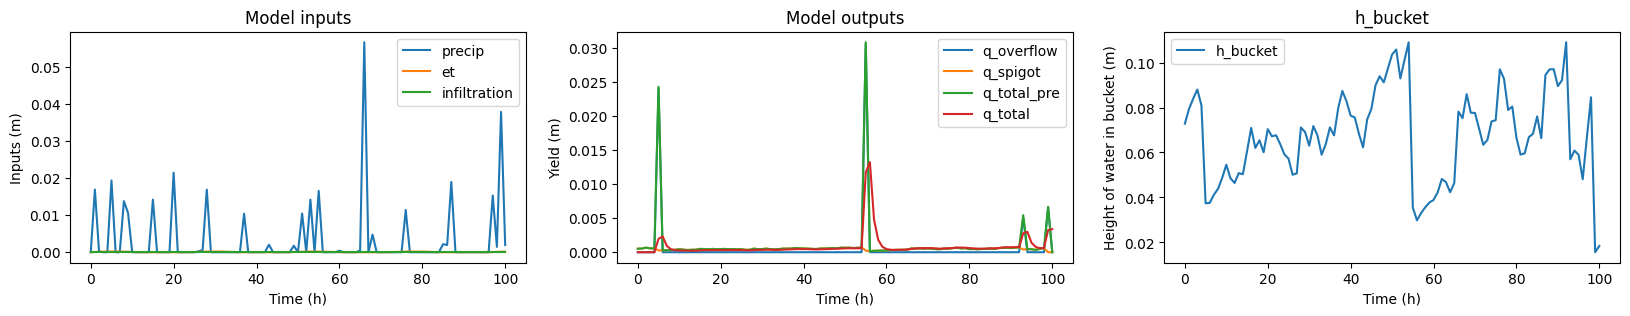

Bucket: 1
Overflow mean (m/h): 0.0
Overflow max (m/h): 0.15
Bucket area (m^2):  13314.68
Spigot area (m^2):  0.0026
Bucket height (m):  0.12
Spigot height (m):  0.033
Geologic permeability (m^2): 1e -13.29
ET (m/day):  0.0017
Soil depth (m):  4.76


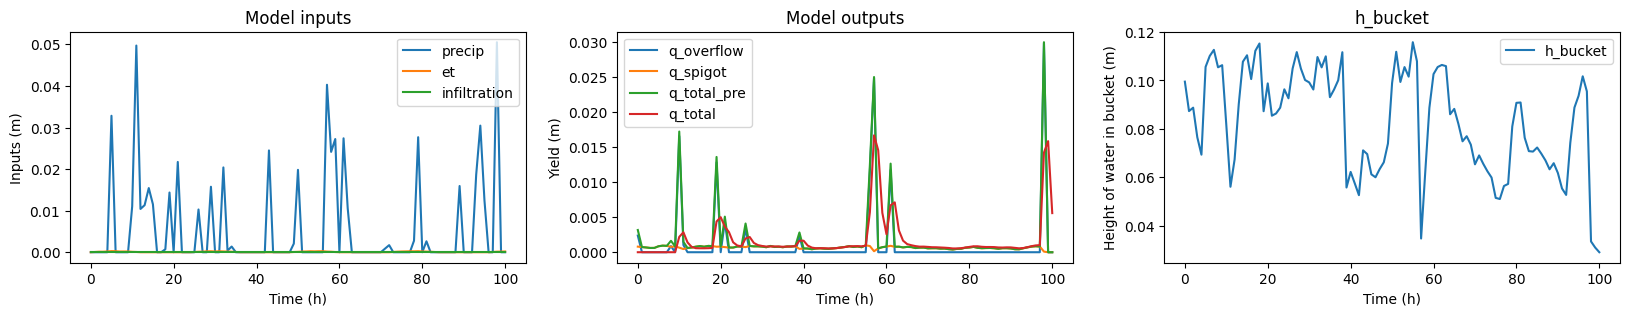

In [44]:
for ibuc in range(n_buckets_per_network):
    viz_simulation(basin_network_dictionary, n_basin_networks_split['train'], ibuc)

We also plot the combined flow of a network to verify the consistency of the transformation function.

In [45]:
def viz_network(basin_network_dictionary, inetwork):
    fig = plt.figure(figsize=(12, 6))

    for ibuc in range(n_buckets_per_network):
        print('Bucket:', ibuc)
        print("Total mean:", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].q_total.mean(),2))
        print("Total max:", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].q_total.max(),2))

        plt.plot(basin_network_dictionary['buckets'][inetwork][ibuc].loc[:100,"q_total"], label='Bucket '+str(ibuc)+' q_total')
        
    q_total_output = basin_network_dictionary['buckets'][inetwork][0].loc[:100,"q_total_output"]

    plt.plot(q_total_output, color='k', linestyle='dashed', label='q_total_output')

    plt.title('Combined streamflows per Network ' + str(inetwork) + ': q_total = q_spigot + q_overflow')
    plt.legend()
    plt.show()
    plt.close()


Bucket: 0
Total mean: 0.0
Total max: 0.1
Bucket: 1
Total mean: 0.0
Total max: 0.08


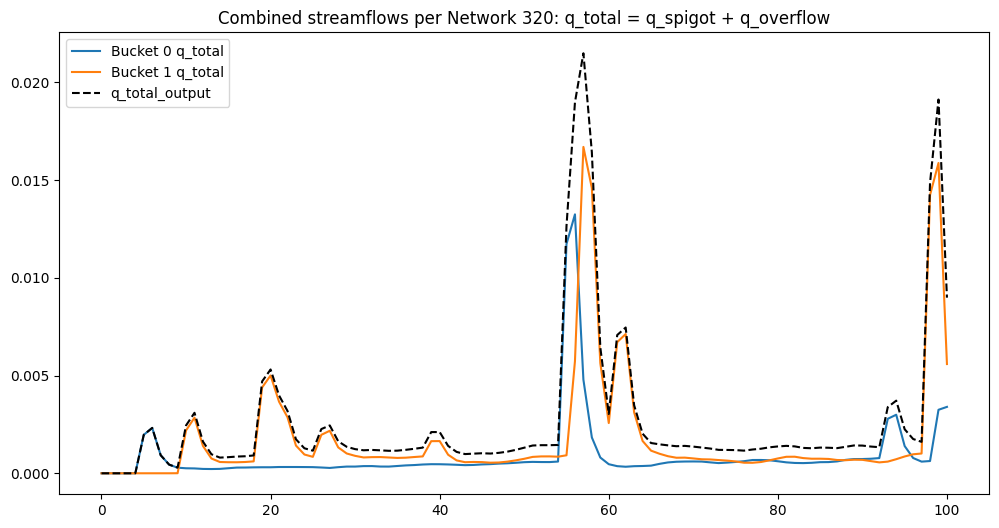

Bucket: 0
Total mean: 0.0
Total max: 0.08
Bucket: 1
Total mean: 0.0
Total max: 0.08


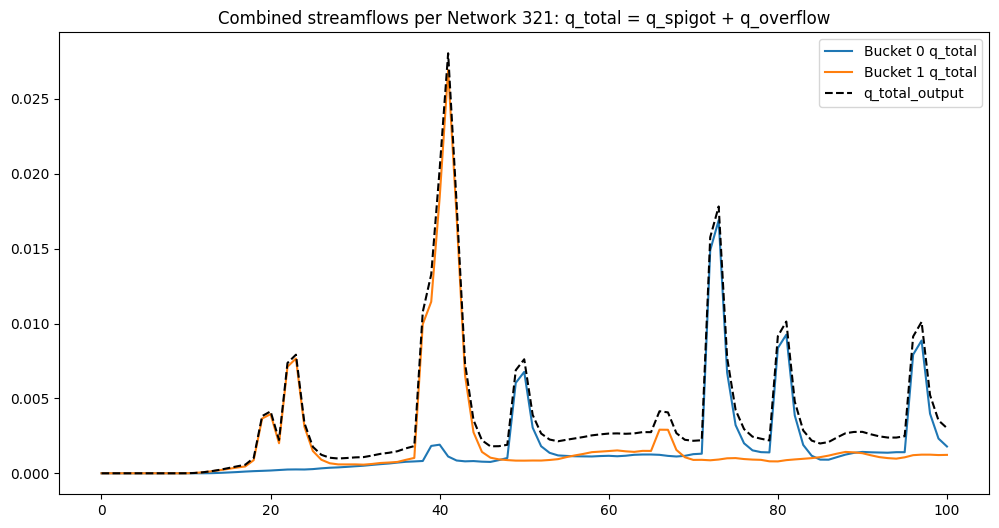

Bucket: 0
Total mean: 0.0
Total max: 0.1
Bucket: 1
Total mean: 0.0
Total max: 0.1


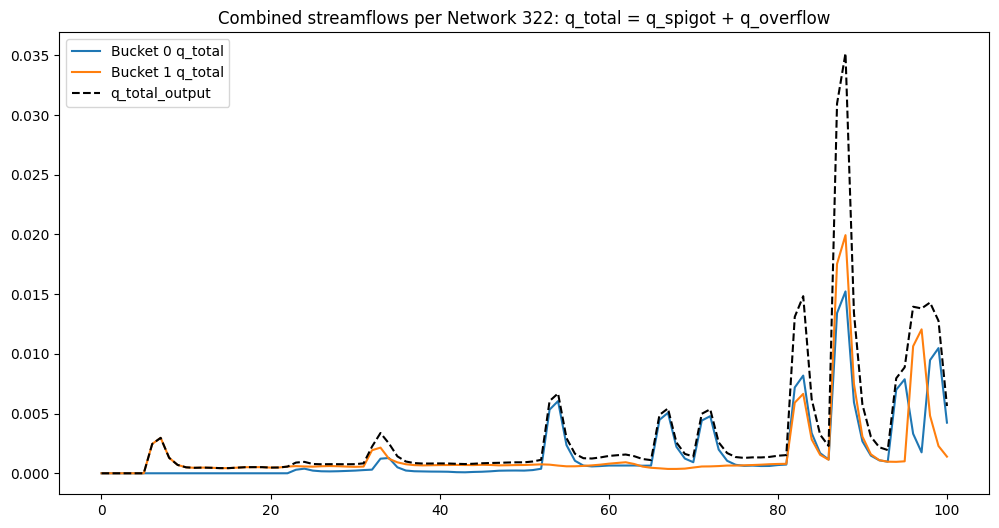

Bucket: 0
Total mean: 0.0
Total max: 0.11
Bucket: 1
Total mean: 0.0
Total max: 0.1


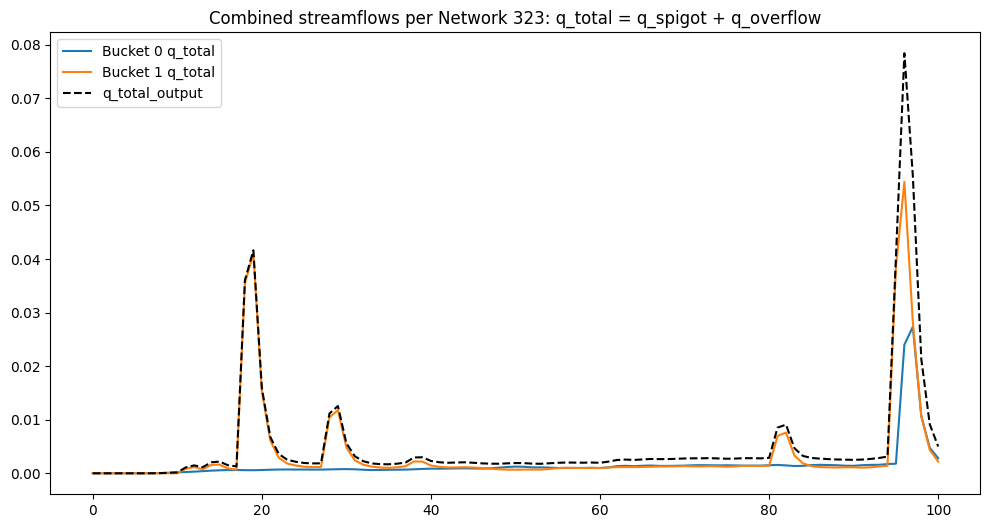

Bucket: 0
Total mean: 0.0
Total max: 0.11
Bucket: 1
Total mean: 0.0
Total max: 0.08


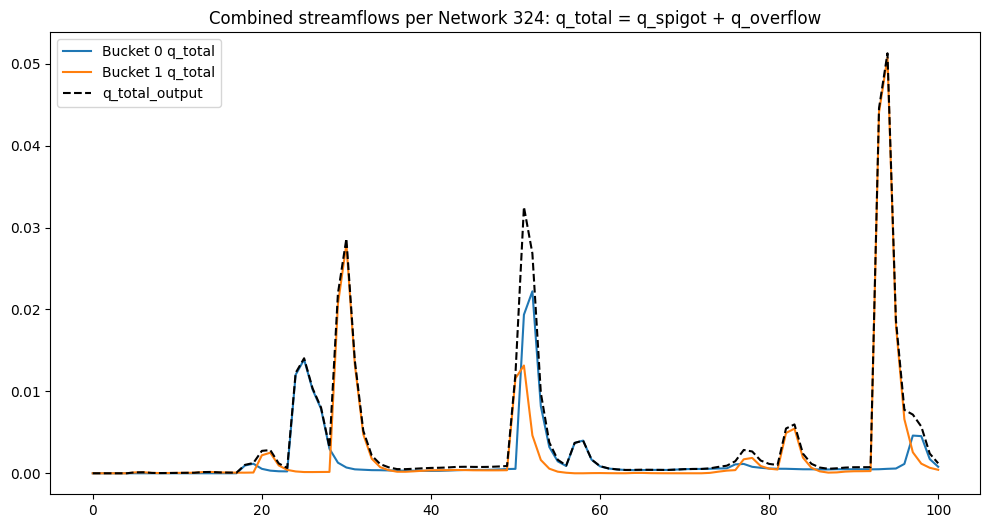

Bucket: 0
Total mean: 0.0
Total max: 0.1
Bucket: 1
Total mean: 0.0
Total max: 0.16


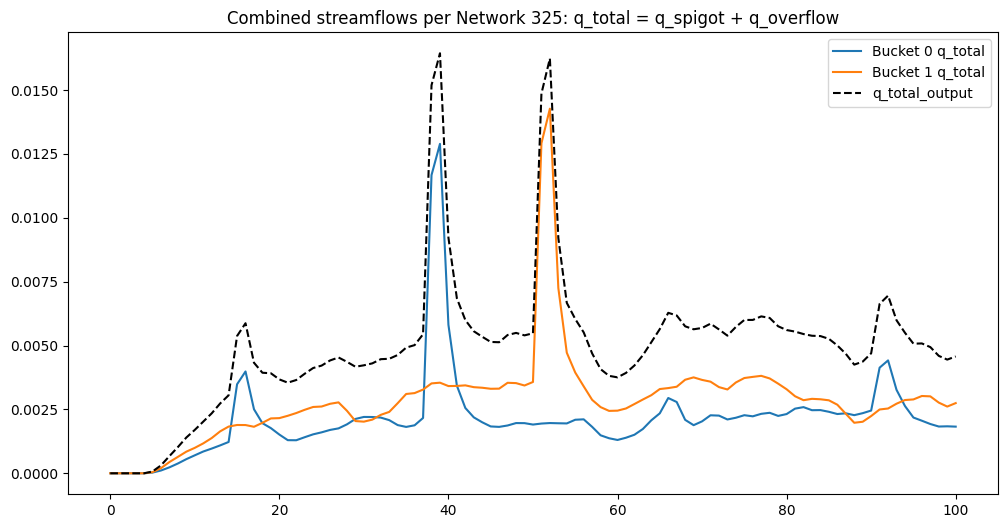

Bucket: 0
Total mean: 0.0
Total max: 0.13
Bucket: 1
Total mean: 0.0
Total max: 0.08


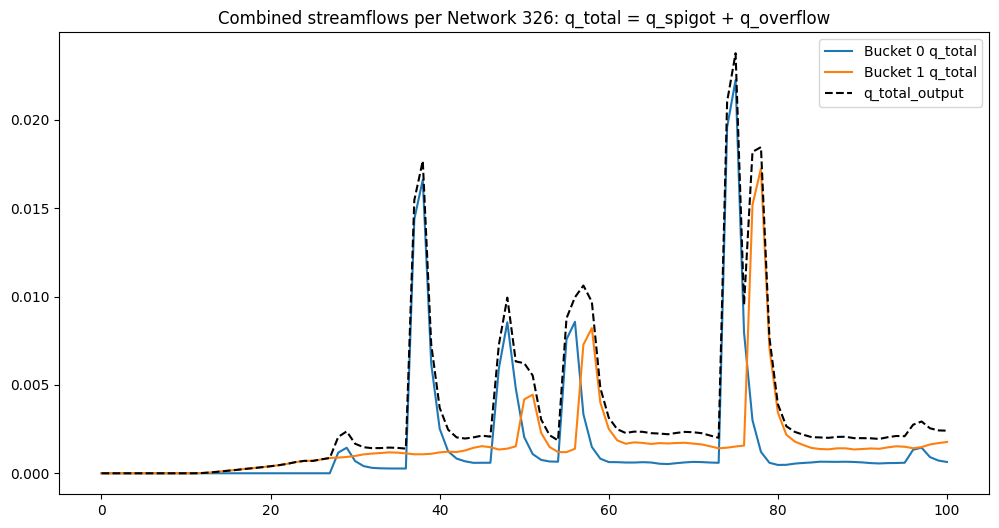

Bucket: 0
Total mean: 0.0
Total max: 0.07
Bucket: 1
Total mean: 0.0
Total max: 0.1


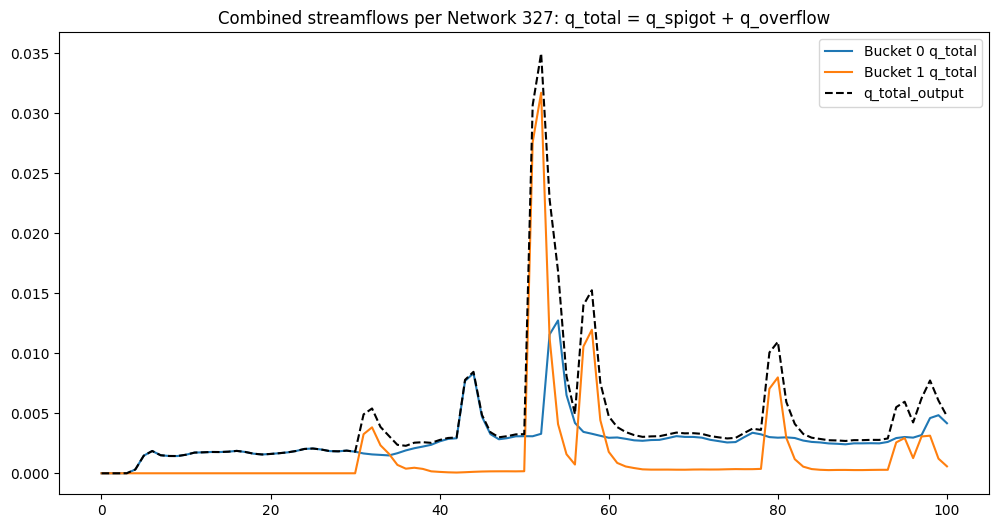

Bucket: 0
Total mean: 0.0
Total max: 0.08
Bucket: 1
Total mean: 0.0
Total max: 0.09


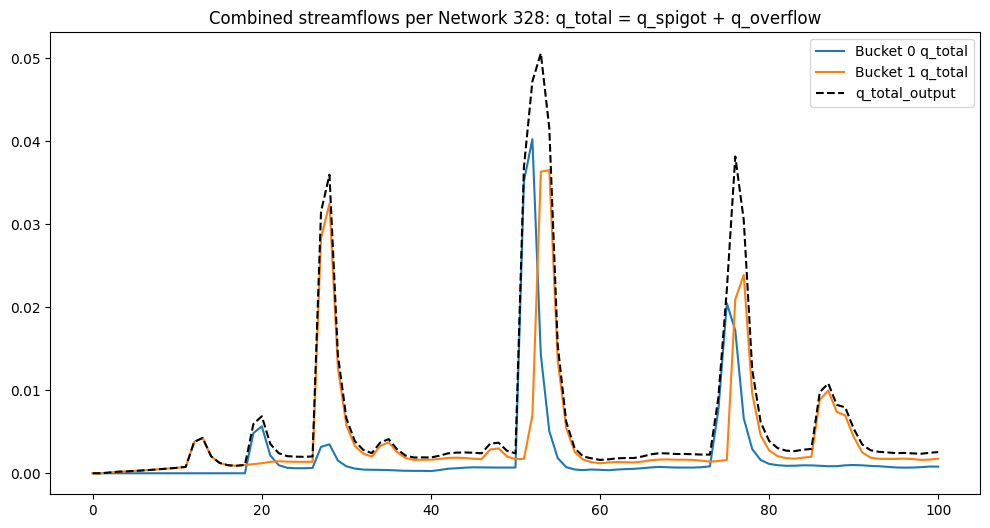

Bucket: 0
Total mean: 0.0
Total max: 0.08
Bucket: 1
Total mean: 0.0
Total max: 0.11


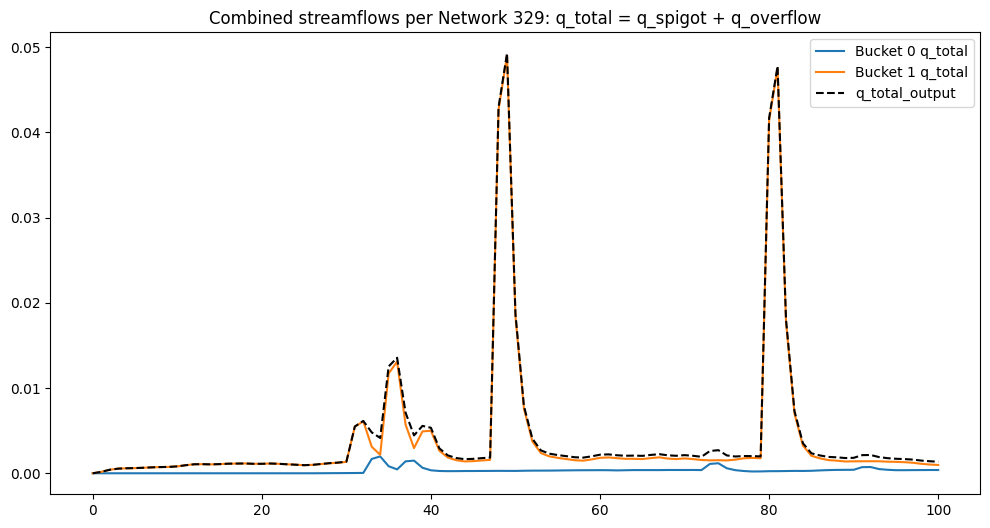

In [46]:
countN = 0
for inetwork in basin_networks_val:
    countN += 1
    viz_network(basin_network_dictionary, inetwork)
    if countN == 10:
        break

# 2. Deep learning model
This section sets up our deep learning model and training procedure.

### 2.1 Defining the neural network model
This is the part of the notebook where we will be using the previous simulations to learn from the generated data and subsequently make predictions. Here, we leverage the simulations to extract valuable insights and apply them in our learning and prediction processes.

Here we define a class called LSTM1, which is a PyTorch module for a multi-layer Long Short-Term Memory (LSTM) network. 

**Architecture**

![Illustration of LSTM Network Architecture](figs/LSTM_Architecture.png)

**Brief explanation**
- The input to the module is a tensor x of shape (`batch_size`, `seq_length`, `input_size`), which represents a sequence of batch_size samples, each of length seq_length, with input_size features at each time step. 
- The LSTM layer is defined using the nn.LSTM class, with input_size as the size of the input layer, hidden_size as the size of the hidden state, and batch_first=True indicating that the first dimension of the input tensor is the batch size. 
- The output of the LSTM layer is passed through a ReLU activation function, and then to a fully connected layer (nn.Linear) with num_classes output units. 
- The forward method takes the input tensor x as an argument, along with an optional tuple `init_states` representing the initial hidden and internal states of the LSTM layer, and returns the output tensor prediction. 
- If `init_states` is not provided, it is initialized as a tensor of zeros with shape (`batch_size`, `hidden_size`).

In [79]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, batch_size, dropout_prob, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length 
        self.batch_size = batch_size
        self.dropout_prob = dropout_prob

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc_1 =  nn.Linear(hidden_size, num_classes) #fully connected 1
   
    def forward(self, x, init_states=None):

        if init_states is None:
            h_t = Variable(torch.zeros(batch_size, self.hidden_size)) # hidden state
            c_t = Variable(torch.zeros(batch_size, self.hidden_size)) # internal state
        else:
            h_t, c_t = init_states
           
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.relu(out)
        prediction = self.fc_1(out) # Dense, fully connected layer
        
        return prediction
    

### 2.2 Defining a procedure for model validation
Here we verify that our model is working the way we expect. We would especially want to check model validation when changing hyperparameters.

We define a function that validates and tests the LSTM model, as well as checks the water balance of the system. 

**Brief explanation**
- We use the pre-defined LSTM model to make predictions on the validation data. 
- The output of this model is then used to compute four different metrics, the Nash-Sutcliffe Efficiency (NSE), Root Mean Sqaure Error (RMSE), Mean Absolute Error (MAE) for the spigot_out, and  mass_overflow columns of the dataframe.
- We plot the actual spigot_out and mass_overflow values against their corresponding LSTM predictions. 
- We check the water balance of the system by summing up the input, evapotranspiration, mass_overflow, spigot_out, and the last recorded water level in the dataframe, and compare this to the total mass out of or left in the system. 
- We print out the percent mass residual as a measure of how well the system is balanced.

In [109]:
def check_validation_period(lstm, np_val_seq_X, basin_network_dictionary, inetwork, n_plot=100, verbose=False):

    def __make_prediction(df):
        lstm_output_val = lstm(torch.Tensor(np_val_seq_X[inetwork][ibuc]).to(device=device))
        #val_spigot_prediction = []
        #val_overflow_prediction = []
        val_total_prediction = []
        for i in range(lstm_output_val.shape[0]):
            #spigot_pred = (lstm_output_val[i,-1,1].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_spigot'])) + np.mean(df.loc[train_start:train_end, 'q_spigot'])
            #overflow_pred = (lstm_output_val[i,-1,0].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_overflow'])) + np.mean(df.loc[train_start:train_end, 'q_overflow'])
            total_pred = (lstm_output_val[i,-1,0].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_total'])) + np.mean(df.loc[train_start:train_end, 'q_total'])
            #spigot_pred = (lstm_output_val[i,-1,1].cpu().detach().numpy() * spigot_std) + spigot_mean
            #overflow_pred = (lstm_output_val[i,-1,0].cpu().detach().numpy() * overflow_std) + overflow_mean

            #spigot_pred = max(spigot_pred, 0)
            #overflow_pred = max(overflow_pred, 0)
            total_pred = max(total_pred, 0)

            #val_spigot_prediction.append(spigot_pred)
            #val_overflow_prediction.append(overflow_pred)
            val_total_prediction.append(total_pred)
            
        #return val_spigot_prediction, val_overflow_prediction, val_total_prediction
        return val_total_prediction

    def __compute_metrics(df, val_total_prediction): #val_spigot_prediction, val_overflow_prediction, 
        '''spigot_out = df.loc[val_start:val_end, 'q_spigot']
        spigot_mean = np.mean(spigot_out)
        spigot_pred_variance = 0
        spigot_obs_variance = 0
        spigot_abs_diff = 0

        overflow_out = df.loc[val_start:val_end, 'q_overflow']
        overflow_mean = np.mean(overflow_out)
        overflow_pred_variance = 0
        overflow_obs_variance = 0
        overflow_abs_diff = 0'''

        total_out = df.loc[val_start:val_end, 'q_total']
        total_mean = np.mean(total_out)
        total_pred_variance = 0
        total_obs_variance = 0
        total_abs_diff = 0

        '''for i, pred_spigot in enumerate(val_spigot_prediction):
            t = i + seq_length - 1
            spigot_pred_variance += np.power((pred_spigot - spigot_out.values[t]), 2)
            spigot_obs_variance += np.power((spigot_mean - spigot_out.values[t]), 2)
            spigot_abs_diff += np.abs(pred_spigot - spigot_out.values[t])

        for i, pred_overflow in enumerate(val_overflow_prediction):
            t = i + seq_length - 1
            overflow_pred_variance += np.power((pred_overflow - overflow_out.values[t]), 2)
            overflow_obs_variance += np.power((overflow_mean - overflow_out.values[t]), 2)            
            overflow_abs_diff += np.abs(pred_overflow - overflow_out.values[t])'''

        for i, pred_total in enumerate(val_total_prediction):
            t = i + seq_length -1
            total_pred_variance += np.power((pred_total - total_out.values[t]), 2)
            total_obs_variance += np.power((total_mean - total_out.values[t]), 2)
            total_abs_diff += np.abs(pred_total - total_out.values[t])

        #spigot_nse = 1 - (spigot_pred_variance / spigot_obs_variance)
        #overflow_nse = 1 - (overflow_pred_variance / overflow_obs_variance)
        total_nse = 1 - (total_pred_variance / total_obs_variance)
        
        #spigot_rmse = np.sqrt(spigot_pred_variance / len(val_spigot_prediction))
        #overflow_rmse = np.sqrt(overflow_pred_variance / len(val_overflow_prediction))
        total_rmse = np.sqrt(total_pred_variance / len(val_total_prediction))
        
        #spigot_mae = spigot_abs_diff / len(val_spigot_prediction)
        #overflow_mae = overflow_abs_diff / len(val_overflow_prediction)
        total_mae = total_abs_diff / len(val_total_prediction)

        #return spigot_nse, overflow_nse, total_nse, spigot_rmse, overflow_rmse, total_rmse, spigot_mae, overflow_mae, total_mae
        return total_nse, total_rmse, total_mae

    
    def __compute_mass_balance(df):
        mass_in = df.sum()['precip']
        mass_out = df.sum()['et'] + df.sum()['q_total'] + df.loc[num_records - 1, 'h_bucket'] + df.sum()['infiltration']
        return mass_in, mass_out

    if verbose: print("*** Network", inetwork, "***")
    
    metrics_list = []
    
    for ibuc in range(n_buckets_per_network):
        df = retrieve_data(inetwork, ibuc, basin_network_dictionary)
        val_total_prediction = __make_prediction(df)
        total_nse, total_rmse, total_mae = __compute_metrics(df, val_total_prediction)
        #val_spigot_prediction, val_overflow_prediction, val_total_prediction = __make_prediction(df)
        #spigot_nse, overflow_nse, total_nse, spigot_rmse, overflow_rmse, total_rmse, spigot_mae, overflow_mae, total_mae = __compute_metrics(df, val_spigot_prediction, val_overflow_prediction, val_total_prediction)
        mass_in, mass_out = __compute_mass_balance(df)

        '''new_row = {'spigot_nse': spigot_nse, 'overflow_nse': overflow_nse, 'total_nse': total_nse, 'spigot_rmse': spigot_rmse, 
                   'overflow_rmse': overflow_rmse, 'total_rmse': total_rmse, 'spigot_mae': spigot_mae, 'overflow_mae': overflow_mae,
                   'total_mae': total_mae, 'mass_in': mass_in, 'mass_out': mass_out}''' 
        new_row = {'total_nse': total_nse, 'total_rmse': total_rmse, 'total_mae': total_mae,
                   'mass_in': mass_in, 'mass_out': mass_out}
        metrics_list.append(new_row)

        if verbose:
            print("Bucket", ibuc)
            #print("NSE Spigot: ", spigot_nse)
            #print("NSE Overflow: ", overflow_nse)
            print("NSE Total: ", total_nse)
            #print("RMSE Spigot: ", spigot_rmse)
            #print("RMSE Overflow: ", overflow_rmse)
            print("RMSE Total: ", total_rmse)
            #print("MAE Spigot: ", spigot_mae)
            #print("MAE Overflow: ", overflow_mae)
            print("MAE Total: ", total_mae)
            print("Mass into the system: ", mass_in)
            print("Mass out or left over:", mass_out)
            print("percent mass residual: {:.0%}".format((mass_in - mass_out) / mass_in))

            fig = plt.figure(figsize=(12, 3))
            ax1 = fig.add_subplot(1, 3, 1)
            ax2 = fig.add_subplot(1, 3, 2)
            ax3 = fig.add_subplot(1, 3, 3)
            '''
            ax1.plot(df.loc[val_start + seq_length - 1:val_start + n_plot + seq_length - 1, 'q_spigot'].values, label = "Spigot out")
            ax1.plot(val_spigot_prediction[:n_plot], label="LSTM spigot out")
            ax1.legend(loc="upper right")
            ax2.plot(df.loc[val_start + seq_length - 1:val_start + n_plot + seq_length - 1, 'q_overflow'].values, label = "Overflow")
            ax2.plot(val_overflow_prediction[:n_plot], label="LSTM Overflow")
            ax2.legend(loc="upper right")'''
            ax3.plot(df.loc[val_start + seq_length - 1:val_start + n_plot + seq_length -1, 'q_total'].values, label = 'Total')
            ax3.plot(val_total_prediction[:n_plot], label='LSTM Total')
            ax3.legend(loc="upper right")
            plt.show()
            plt.close()
    
    metrics_df = pd.DataFrame(metrics_list)
    avg_metrics = metrics_df[['total_nse', 'total_rmse', 'total_mae']].mean()
    #avg_metrics = metrics_df[['spigot_nse', 'overflow_nse', 'total_nse', 'spigot_rmse', 'overflow_rmse', 'total_rmse', 'spigot_mae', 'overflow_mae', 'total_mae']].mean()
    total_mass_in = metrics_df['mass_in'].sum()
    total_mass_out = metrics_df['mass_out'].sum()
    total_mass_residual_percent = (total_mass_in - total_mass_out) / total_mass_in

    network_metrics_df = pd.DataFrame([avg_metrics])
    network_metrics_df['total_mass_in'] = total_mass_in
    network_metrics_df['total_mass_out'] = total_mass_out
    network_metrics_df['total_mass_residual_percent'] = total_mass_residual_percent

    if verbose:
        print("*** Network Metrics ***")
        print("Network", inetwork)
        #print("NSE Spigot: ", network_metrics_df['spigot_nse'].iloc[0])
        #print("NSE Overflow: ", network_metrics_df['overflow_nse'].iloc[0])
        print("NSE Total: ", network_metrics_df['total_nse'].iloc[0])
        #print("RMSE Spigot: ", network_metrics_df['spigot_rmse'].iloc[0])
        #print("RMSE Overflow: ", network_metrics_df['overflow_rmse'].iloc[0])
        print("RMSE Total: ", network_metrics_df['total_rmse'].iloc[0])
        #print("MAE Spigot: ", network_metrics_df['spigot_mae'].iloc[0])
        #print("MAE Overflow: ", network_metrics_df['overflow_mae'].iloc[0])
        print("MAE Total: ", network_metrics_df['total_mae'].iloc[0])
        print("Mass into the system: ", network_metrics_df['total_mass_in'].iloc[0])
        print("Mass out or left over:", network_metrics_df['total_mass_out'].iloc[0])
        print("Percent mass residual: {:.0%}".format(network_metrics_df['total_mass_residual_percent'].iloc[0]))

    return network_metrics_df


In [117]:
def check_validation_period_combined(lstm_combined, combined_np_val_seq_X, combined_network_dictionary, inetwork, n_plot=100, verbose=False):
    def __make_prediction(df, ibuc):
        lstm_output_val = lstm_combined(torch.Tensor(combined_np_val_seq_X[inetwork]).to(device=device))
        #val_spigot_prediction = []
        #val_overflow_prediction = []
        val_total_prediction = []

        for i in range(lstm_output_val.shape[0]):
            #spigot_pred = (lstm_output_val[i, -1, (ibuc * 2) + 1].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_spigot_b' + str(ibuc)])) + np.mean(df.loc[train_start:train_end, 'q_spigot_b' + str(ibuc)])
            #overflow_pred = (lstm_output_val[i, -1, (ibuc * 2)].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_overflow_b' + str(ibuc)])) + np.mean(df.loc[train_start:train_end, 'q_overflow_b' + str(ibuc)])
            total_pred = (lstm_output_val[i, -1, (ibuc)].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_total_b' + str(ibuc)])) + np.mean(df.loc[train_start:train_end, 'q_total_b' + str(ibuc)])
            #spigot_pred = (lstm_output_val[i, -1, (ibuc * 2) + 1].cpu().detach().numpy() * spigot_std) + spigot_mean
            #overflow_pred = (lstm_output_val[i, -1, (ibuc * 2)].cpu().detach().numpy() * overflow_std) + overflow_mean

            #spigot_pred = max(spigot_pred, 0)
            #overflow_pred = max(overflow_pred, 0)
            total_pred = max(total_pred, 0)

            #val_spigot_prediction.append(spigot_pred)
            #val_overflow_prediction.append(overflow_pred)
            val_total_prediction.append(total_pred)

        #return val_spigot_prediction, val_overflow_prediction, val_total_prediction
        return val_total_prediction

    def __compute_metrics_combined(df, val_total_prediction, ibuc): #val_spigot_prediction, val_overflow_prediction, 
        # Use specific columns for each bucket
        '''spigot_out = df.loc[val_start:val_end, 'q_spigot_b' + str(ibuc)]
        spigot_mean = np.mean(spigot_out)
        spigot_pred_variance = 0
        spigot_obs_variance = 0
        spigot_abs_diff = 0

        overflow_out = df.loc[val_start:val_end, 'q_overflow_b' + str(ibuc)]
        overflow_mean = np.mean(overflow_out)
        overflow_pred_variance = 0
        overflow_obs_variance = 0
        overflow_abs_diff = 0'''

        total_out = df.loc[val_start:val_end, 'q_total_b' + str(ibuc)]
        total_mean = np.mean(total_out)
        total_pred_variance = 0
        total_obs_variance = 0
        total_abs_diff = 0

        '''for i, pred_spigot in enumerate(val_spigot_prediction):
            t = i + seq_length - 1
            spigot_pred_variance += np.power((pred_spigot - spigot_out.iloc[t]), 2)
            spigot_obs_variance += np.power((spigot_mean - spigot_out.iloc[t]), 2)
            spigot_abs_diff += np.abs(pred_spigot - spigot_out.iloc[t])

        for i, pred_overflow in enumerate(val_overflow_prediction):
            t = i + seq_length - 1
            overflow_pred_variance += np.power((pred_overflow - overflow_out.iloc[t]), 2)
            overflow_obs_variance += np.power((overflow_mean - overflow_out.iloc[t]), 2)            
            overflow_abs_diff += np.abs(pred_overflow - overflow_out.iloc[t])'''

        for i, pred_total in enumerate(val_total_prediction):
            t = 1 + seq_length -1
            total_pred_variance += np.power((pred_total - total_out.iloc[t]), 2)
            total_obs_variance += np.power((total_mean - total_out.iloc[t]), 2)
            total_abs_diff += np.abs(pred_total - total_out.iloc[t])

        #spigot_nse = 1 - (spigot_pred_variance / spigot_obs_variance)
        #overflow_nse = 1 - (overflow_pred_variance / overflow_obs_variance)
        total_nse = 1 - (total_pred_variance / total_obs_variance)
        
        #spigot_rmse = np.sqrt(spigot_pred_variance / len(val_spigot_prediction))
        #overflow_rmse = np.sqrt(overflow_pred_variance / len(val_overflow_prediction))
        total_rmse = np.sqrt(total_pred_variance / len(val_total_prediction))
        
        #spigot_mae = spigot_abs_diff / len(val_spigot_prediction)
        #overflow_mae = overflow_abs_diff / len(val_overflow_prediction)
        total_mae = total_abs_diff / len(val_total_prediction)

        #return spigot_nse, overflow_nse, total_nse, spigot_rmse, overflow_rmse, total_rmse, spigot_mae, overflow_mae, total_mae
        return total_nse, total_rmse, total_mae

    def __compute_mass_balance_combined(df, ibuc):
        suffix = '_b' + str(ibuc)  # Suffix to identify the specific bucket
        mass_in = df.sum()['precip' + suffix]
        mass_out = df.sum()['et' + suffix] + df.sum()['q_total' + suffix] + df.sum()['infiltration' + suffix] + df['h_bucket' + suffix].iloc[-1]
        return mass_in, mass_out

    if verbose: print("*** Network", inetwork, "***")

    df = retrieve_combined_data(inetwork, combined_network_dictionary)  # Retrieves the combined DataFrame for this network
    metrics_list = []

    for ibuc in range(n_buckets_per_network):
        # Prediction is made with the combined DataFrame, but specifying the bucket
        #val_spigot_prediction, val_overflow_prediction, val_total_prediction = __make_prediction(df, ibuc)
        val_total_prediction = __make_prediction(df, ibuc)
        # Compute the metrics for the predictions of this bucket
        #spigot_nse, overflow_nse, total_nse, spigot_rmse, overflow_rmse, total_rmse, spigot_mae, overflow_mae, total_mae = __compute_metrics_combined(df, val_spigot_prediction, val_overflow_prediction, val_total_prediction, ibuc)
        total_nse, total_rmse, total_mae = __compute_metrics_combined(df, val_total_prediction, ibuc)
        mass_in, mass_out = __compute_mass_balance_combined(df, ibuc)

        new_row = {
            #'spigot_nse': spigot_nse, 'overflow_nse': overflow_nse, 
            'total_nse': total_nse,
            #'spigot_rmse': spigot_rmse, 'overflow_rmse': overflow_rmse, 
            'total_rmse': total_rmse,
            #'spigot_mae': spigot_mae, 'overflow_mae': overflow_mae, 
            'total_mae': total_mae,
            'mass_in': mass_in, 'mass_out': mass_out
        }
        metrics_list.append(new_row)

        if verbose:

            print("Bucket", ibuc)
            #print("NSE Spigot: ", spigot_nse)
            #print("NSE Overflow: ", overflow_nse)
            print("NSE Total: ", total_nse)
            #print("RMSE Spigot: ", spigot_rmse)
            #print("RMSE Overflow: ", overflow_rmse)
            print("RMSE Total: ", total_rmse)
            #print("MAE Spigot: ", spigot_mae)
            #print("MAE Overflow: ", overflow_mae)
            print("MAE Total: ", total_mae)
            print("Mass into the system: ", mass_in)
            print("Mass out or left over:", mass_out)
            print("Percent mass residual: {:.0%}".format((mass_in - mass_out) / mass_in))

            # Plot the predictions for this bucket
            fig = plt.figure(figsize=(12, 3))
            ax1 = fig.add_subplot(1, 3, 1)
            ax2 = fig.add_subplot(1, 3, 2)
            ax3 = fig.add_subplot(1, 3, 3)
            '''ax1.plot(df.loc[val_start + seq_length - 1:val_start + n_plot + seq_length - 1, 'q_spigot_b' + str(ibuc)].values, label = "Spigot out")
            ax1.plot(val_spigot_prediction[:n_plot], label="LSTM spigot out")
            ax1.legend(loc="upper right")
            ax2.plot(df.loc[val_start + seq_length - 1:val_start + n_plot + seq_length - 1, 'q_overflow_b' + str(ibuc)].values, label = "Overflow")
            ax2.plot(val_overflow_prediction[:n_plot], label="LSTM Overflow")
            ax2.legend(loc="upper right")'''
            ax3.plot(df.loc[val_start + seq_length - 1:val_start + n_plot + seq_length - 1, 'q_total_b' + str(ibuc)].values, label = "Total")
            ax3.plot(val_total_prediction[:n_plot], label="LSTM Total")
            ax3.legend(loc="upper right")
            plt.show()
            plt.close()

    metrics_df = pd.DataFrame(metrics_list)
    avg_metrics = metrics_df[['total_nse', 'total_rmse', 'total_mae']].mean()
    #avg_metrics = metrics_df[['spigot_nse', 'overflow_nse', 'total_nse', 'spigot_rmse', 'overflow_rmse', 'total_rmse', 'spigot_mae', 'overflow_mae', 'total_mae']].mean()
    total_mass_in = metrics_df['mass_in'].sum()
    total_mass_out = metrics_df['mass_out'].sum()
    total_mass_residual_percent = (total_mass_in - total_mass_out) / total_mass_in

    #network_metrics_df = avg_metrics.to_frame().transpose()
    network_metrics_df = pd.DataFrame([avg_metrics])
    network_metrics_df['total_mass_in'] = total_mass_in
    network_metrics_df['total_mass_out'] = total_mass_out
    network_metrics_df['total_mass_residual_percent'] = total_mass_residual_percent

    if verbose:
        print("*** Network Metrics ***")
        print("Network", inetwork)
        #print("NSE Spigot: ", network_metrics_df['spigot_nse'].iloc[0])
        #print("NSE Overflow: ", network_metrics_df['overflow_nse'].iloc[0])
        print("NSE Total: ", network_metrics_df['total_nse'].iloc[0])
        #print("RMSE Spigot: ", network_metrics_df['spigot_rmse'].iloc[0])
        #print("RMSE Overflow: ", network_metrics_df['overflow_rmse'].iloc[0])
        print("RMSE Total: ", network_metrics_df['total_rmse'].iloc[0])
        #print("MAE Spigot: ", network_metrics_df['spigot_mae'].iloc[0])
        #print("MAE Overflow: ", network_metrics_df['overflow_mae'].iloc[0])
        print("MAE Total: ", network_metrics_df['total_mae'].iloc[0])
        print("Mass into the system: ", network_metrics_df['total_mass_in'].iloc[0])
        print("Mass out or left over: ", network_metrics_df['total_mass_out'].iloc[0])
        print("Percent mass residual: {:.0%}".format(network_metrics_df['total_mass_residual_percent'].iloc[0]))

    return network_metrics_df


### 2.3 Instantiating the neural network model (LSTM)

Using the hyperparameters from Section 1.2, we define a specific instance of the LSTM model and set up the LSTM

In [82]:
hidden_state_size_individual = 256
num_layers_individual = 2
num_epochs_individual = 10

batch_size=128
dropout_prob = 0.2

hidden_state_size_combined = 256
num_layers_combined = 2
num_epochs_combined = 10

In [83]:
## For individual bucket inputs without combined downstream flow data
torch.manual_seed(1)
lstm_individual = LSTM1(num_classes=n_output,  
                        input_size=n_indvidual_input,    
                        hidden_size=hidden_state_size_individual, 
                        num_layers=num_layers_individual, 
                        batch_size=batch_size, 
                        dropout_prob=dropout_prob,
                        seq_length=seq_length).to(device=device)

In [84]:
## For individual bucket inputs with combined downstream flow data
torch.manual_seed(1)
lstm = LSTM1(num_classes=n_output,  
             input_size=n_input,    
             hidden_size=hidden_state_size_individual, 
             num_layers=num_layers_individual, 
             batch_size=batch_size, 
             dropout_prob=dropout_prob,
             seq_length=seq_length).to(device=device)

In [85]:
## For combined bucket network inputs with combined downstream flow data
torch.manual_seed(1)
lstm_combined = LSTM1(num_classes=n_combined_output,  
                        input_size=n_combined_input,    
                        hidden_size=hidden_state_size_combined, 
                        num_layers=num_layers_combined, 
                        batch_size=batch_size, 
                        dropout_prob=dropout_prob,
                        seq_length=seq_length).to(device=device)

In [86]:
print(n_indvidual_input, n_output, seq_length)
print(n_input, n_output, seq_length)
print(n_combined_input, n_combined_output, seq_length)

4 1 24
5 1 24
9 2 24


### 2.4 Setting up the data to feed into the model

We will set up data for:
- training, to calculate the loss which is backpropogated through the model
- validation, where we get predictions from the trained model and see if the performance is up to our standards
- testing, the data we will utimately use to report the LSTM performance. 

Note: testing is the last thing we would do, if we go back to validation after this step, we would be P-hacking.

**Fitting a scaler to the training set to transform all the data**

Here we fit a scaler to the training set, allowing for the transformation of input and output variables to a normalized and standardized scale, which helps in training the model and maintaining consistency across different datasets. This normalization step ensures that the data is suitable for training our LSTM model. 

In [87]:
def fit_scaler(input_vars, basin_network_dictionary):
    # Adjust scaler for input
    frames = [basin_network_dictionary['buckets'][inetwork][ibuc].loc[train_start:train_end, input_vars] for inetwork in basin_networks_train for ibuc in range(n_buckets_per_network)]
    df_in = pd.concat(frames)    
    scaler_in = StandardScaler()
    scaler_train_in = scaler_in.fit_transform(df_in)

    # Adjust scaler for output
    scaler_out = []
    for ibuc in range(n_buckets_per_network):
        frames = [basin_network_dictionary['buckets'][inetwork][ibuc].loc[train_start:train_end, output_vars[ibuc]] for inetwork in basin_networks_train]
        df_out = pd.concat(frames)
        scaler = StandardScaler()
        scaler_train_out = scaler.fit_transform(df_out)
        scaler_out.append(scaler)

    return scaler_in, scaler_out


In [88]:
def fit_combined_scaler(combined_network_dictionary):
    # Adjust scaler for combined input
    frames_in = [combined_network_dictionary['networks'][inetwork].loc[train_start:train_end, input_combined_vars] for inetwork in basin_networks_train]
    df_in_combined = pd.concat(frames_in)
    scaler_in_combined = StandardScaler()
    scaler_train_in_combined = scaler_in_combined.fit_transform(df_in_combined)
    # Adjust scaler for combined output
    frames_out = [combined_network_dictionary['networks'][inetwork].loc[train_start:train_end, output_combined_vars] for inetwork in basin_networks_train]
    df_out_combined = pd.concat(frames_out)
    scaler_out_combined = StandardScaler()
    scaler_train_out_combined = scaler_out_combined.fit_transform(df_out_combined)

    return scaler_in_combined, scaler_out_combined



In [89]:
## For individual bucket inputs without combined downstream flow data
individual_scaler_in, individual_scaler_out = fit_scaler(input_individual_vars, basin_network_dictionary)

In [90]:
## For individual bucket inputs with combined downstream flow data
scaler_in, scaler_out = fit_scaler(input_vars, basin_network_dictionary)

In [91]:
## For combined bucket network inputs with combined downstream flow data
scaler_in_combined, scaler_out_combined = fit_combined_scaler(combined_network_dictionary)

**Function to create data loader for each data split**

We prepare and organize the data for training. We create data loaders that handle batch processing and shuffling of the data. We also add some preprocessing steps such as scaling the input and output variables. The data loaders and numpy arrays are used for feeding the data into the neural network during the training process.

In [92]:
def make_data_loader(start, end, basin_networks_list, basin_network_dictionary, input_vars, scaler_in, scaler_out, n_input): ## For individual bucket inputs
    loader = {}
    np_seq_X = {}
    np_seq_y = {}
    
    # Traverse the networks in the provided list
    for inetwork in basin_networks_list:
        np_seq_X[inetwork] = {}
        np_seq_y[inetwork] = {}
        for ibuc in range(n_buckets_per_network):
            # Each dataframe in the network covers the same time range
            df = basin_network_dictionary['buckets'][inetwork][ibuc]
            # We transform the whole dataframe, instead of a specific time range
            scaler_in_i = scaler_in.transform(df.loc[start:end, input_vars])
            scaler_out_i = scaler_out[ibuc].transform(df.loc[start:end, output_vars[ibuc]])

            np_seq_X_ibuc = np.zeros((scaler_in_i.shape[0] - seq_length, seq_length, n_input))
            np_seq_y_ibuc = np.zeros((scaler_out_i.shape[0] - seq_length, seq_length, n_output))
            
            for i in range(0, scaler_in_i.shape[0] - seq_length):
                t = i + seq_length
                np_seq_X_ibuc[i, :, :] = scaler_in_i[i:t,:]
                np_seq_y_ibuc[i, :, :] = scaler_out_i[i:t,:]

            ds = torch.utils.data.TensorDataset(torch.Tensor(np_seq_X_ibuc), 
                                                torch.Tensor(np_seq_y_ibuc))
            
            loader[inetwork * n_buckets_per_network + ibuc] = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
            np_seq_X[inetwork][ibuc] = np_seq_X_ibuc
            np_seq_y[inetwork][ibuc] = np_seq_y_ibuc
    
    return loader, np_seq_X, np_seq_y


In [93]:
def make_combined_data_loader(start, end, basin_networks_list, combined_network_dictionary, input_combined_vars, output_combined_vars, scaler_in_combined, scaler_out_combined, n_combined_input):
    loader = {}
    np_seq_X = {}
    np_seq_y = {}
    
    # Traverse the networks in the provided list
    for inetwork in basin_networks_list:
        # Assuming each dataframe in the network covers the same time range
        df_combined = combined_network_dictionary['networks'][inetwork]
        
        # Transform the whole dataframe for inputs
        scaler_in_i = scaler_in_combined.transform(df_combined.loc[start:end, input_combined_vars])
        np_seq_X_ibuc = np.zeros((scaler_in_i.shape[0] - seq_length, seq_length, n_combined_input))
        
        for i in range(scaler_in_i.shape[0] - seq_length):
            t = i + seq_length
            np_seq_X_ibuc[i, :, :] = scaler_in_i[i:t, :]

        # Prepare the output data
        scaler_out_i = scaler_out_combined.transform(df_combined.loc[start:end, output_combined_vars])
        np_seq_y_ibuc = np.zeros((scaler_out_i.shape[0] - seq_length, seq_length, n_combined_output))
            
        for i in range(scaler_out_i.shape[0] - seq_length):
            t = i + seq_length
            np_seq_y_ibuc[i, :, :] = scaler_out_i[i:t, :]
            
        np_seq_y[inetwork] = np_seq_y_ibuc

        # Create data loaders
        ds = torch.utils.data.TensorDataset(torch.Tensor(np_seq_X_ibuc), torch.Tensor(np_seq_y[inetwork]))
        loader[inetwork] = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
            
        np_seq_X[inetwork] = np_seq_X_ibuc
    
    return loader, np_seq_X, np_seq_y


We use the function above and parameters defined in the notebook environment to generate the training, validation, test data loaders

In [94]:
## For individual bucket inputs without combined downstream flow data
individual_train_loader, individual_np_train_seq_X, individual_np_train_seq_y = make_data_loader(train_start, train_end, basin_networks_train, basin_network_dictionary, input_individual_vars, individual_scaler_in, individual_scaler_out, n_indvidual_input)
individual_val_loader, individual_np_val_seq_X, individual_np_val_seq_y = make_data_loader(val_start, val_end, basin_networks_val, basin_network_dictionary, input_individual_vars, individual_scaler_in, individual_scaler_out, n_indvidual_input)
individual_test_loader, individual_np_test_seq_X, individual_np_test_seq_y = make_data_loader(test_start, test_end, basin_networks_test, basin_network_dictionary, input_individual_vars, individual_scaler_in, individual_scaler_out, n_indvidual_input)


In [95]:
## For individual bucket inputs with combined downstream flow data
train_loader, np_train_seq_X, np_train_seq_y = make_data_loader(train_start, train_end, basin_networks_train, basin_network_dictionary, input_vars, scaler_in, scaler_out, n_input)
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(val_start, val_end, basin_networks_val, basin_network_dictionary, input_vars, scaler_in, scaler_out, n_input)
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(test_start, test_end, basin_networks_test, basin_network_dictionary, input_vars, scaler_in, scaler_out, n_input)

In [96]:
## For combined bucket network inputs with combined downstream flow data
combined_train_loader, combined_np_train_seq_X, combined_np_train_seq_y = make_combined_data_loader(train_start, train_end, basin_networks_train, combined_network_dictionary, input_combined_vars, output_combined_vars, scaler_in_combined, scaler_out_combined, n_combined_input)
combined_val_loader, combined_np_val_seq_X, combined_np_val_seq_y = make_combined_data_loader(val_start, val_end, basin_networks_val, combined_network_dictionary, input_combined_vars, output_combined_vars, scaler_in_combined, scaler_out_combined, n_combined_input)
combined_test_loader, combined_np_test_seq_X, combined_np_test_seq_y = make_combined_data_loader(test_start, test_end, basin_networks_test, combined_network_dictionary, input_combined_vars, output_combined_vars, scaler_in_combined, scaler_out_combined, n_combined_input)

### 2.5 Training the model: Learning the general response of the example dynamic ''hydrologic" system
Now is the time to train the model! Everything above was done in preparation for this step.

Here we define a function to train the LSTM neural network model with the nn.MSELoss() loss function and using the Adam optimizer and hyperparameters defined above.

**Brief explanation**:
- The training is done for a specified number of epochs.
- For each epoch, the individual characteristics of each bucket and the combined flow of the entire network are processed.
- Data from each basin network are loaded using a PyTorch DataLoader and passed through the LSTM model to predict the individual flow and overflow for each bucket in the network.
- The output is then compared with the target values using the custom loss function. 
- The gradients are calculated and the optimizer is used to update the weights of the model. 
- We use the tqdm library to show the progress of the training. 
- Finally, we estimate the average RMSE for each epoch. 

In [97]:
def train_model(lstm, train_loader, basin_networks_train, learning_rate, num_epochs):
    criterion = nn.MSELoss()
    criterion = criterion.to(device=device) 
        
    optimizer = optim.Adam(lstm.parameters(), lr = learning_rate[0])
    epoch_bar = tqdm(range(num_epochs), desc = "Training", position = 0, total = num_epochs)

    # Create a dictionary to store the results
    results = {}

    for epoch in epoch_bar:
        for inetwork in basin_networks_train:
            # Initialize results for each network at the beginning
            if inetwork not in results:
                results[inetwork] = {"loss": [], "RMSE": []}

            batch_bar = tqdm(enumerate(train_loader[inetwork]),
                             desc="Network: {}, Epoch: {}".format(str(inetwork), str(epoch)),
                             position = 1, total = len(train_loader[inetwork]), leave = False, disable = True)

            for i, (data, targets) in batch_bar:

                optimizer.zero_grad()

                optimizer = optim.Adam(lstm.parameters(), lr = learning_rate[epoch])

                data = data.to(device = device)
                targets = targets.to(device = device)

                # Forward
                lstm_output = lstm(data)
                loss = criterion(lstm_output, targets)

                #backward
                optimizer.zero_grad()
                loss.backward()

                # gradient descent or adam step
                optimizer.step()

                batch_bar.set_postfix(loss = loss.to(device).item(),
                                      RMSE = "{:.2f}".format(loss ** (1 / 2)),
                                      epoch = epoch)
                batch_bar.update()

            with torch.no_grad():
                rmse_list = []
                for i, (data_, targets_) in enumerate(train_loader[inetwork]):
                    data_ = data_.to(device = device)
                    targets_ = targets_.to(device = device)

                    lstm_output_ = lstm(data_)
                    MSE_ = criterion(lstm_output_, targets_)
                    rmse_list.append(MSE_ ** (1 / 2))

            #meanrmse = np.mean(np.array(torch.Tensor(rmse_list)))
            meanrmse = torch.stack(rmse_list).mean().item()
            epoch_bar.set_postfix(loss = loss.cpu().item(),
                                  RMSE = "{:.2f}".format(meanrmse),
                                  epoch = epoch)

            results[inetwork]["loss"].append(loss.cpu().item())
            results[inetwork]["RMSE"].append(meanrmse)

            batch_bar.update()

        #clear_output()

    return lstm, results

Run the train model functon by prescribing the buckets and data to use for training and the intantiated LSTM

In [98]:
## For individual bucket inputs without combined downstream flow data
lstm_individual, results_individual = train_model(lstm_individual, individual_train_loader, basin_networks_train, learning_rate_individual, num_epochs_individual)


Training:   0%|          | 0/10 [00:00<?, ?it/s]

In [99]:
import IPython

In [100]:
## For individual bucket inputs with combined downstream flow data
lstm, results = train_model(lstm, train_loader, basin_networks_train, learning_rate_individual, num_epochs_individual)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

In [101]:
## For combined bucket network inputs with combined downstream flow data
lstm_combined, results_combined = train_model(lstm_combined, combined_train_loader, basin_networks_train, learning_rate_combined, num_epochs_combined)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

### 2.5 Visualizing the learning curves

 We plot the loss and root mean square error (RMSE) metrics for each epoch to check if the model fitting has converged

In [102]:
def viz_learning_curve(results):
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for inetwork in basin_networks_train:
        num_epochs_executed = len(results[inetwork]['loss'])
        ax1.plot(range(num_epochs_executed), results[inetwork]['loss'])
        ax2.plot(range(num_epochs_executed), results[inetwork]['RMSE'])
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('RMSE')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    plt.suptitle("Learning curves for each network") 
    plt.show()


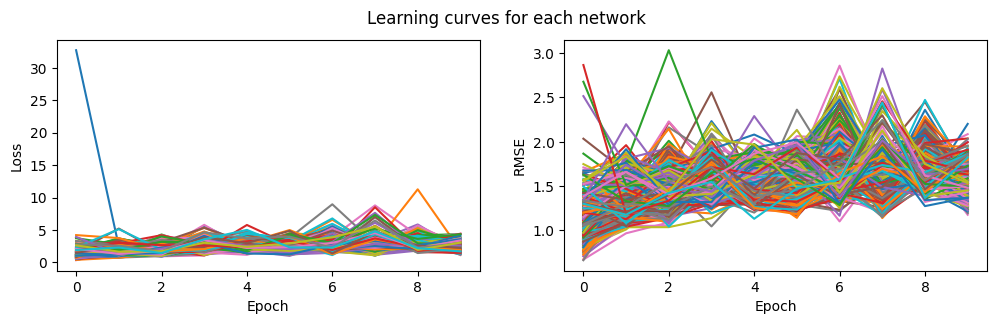

In [103]:
## For individual bucket inputs without combined downstream flow data
viz_learning_curve(results_individual)

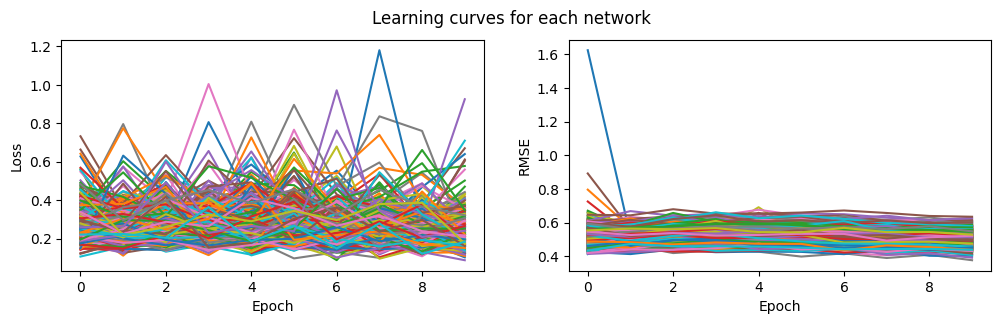

In [104]:
## For individual bucket inputs with combined downstream flow data
viz_learning_curve(results)

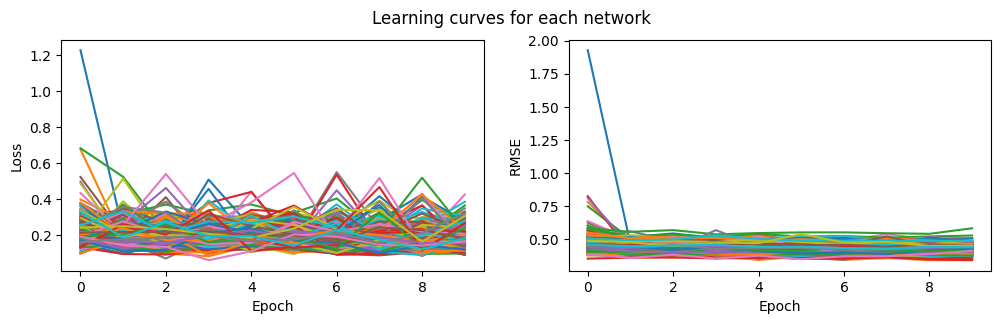

In [105]:
## For combined bucket network inputs with combined downstream flow data
viz_learning_curve(results_combined)

### 2.6 Checking that the model works on the validation data
Now that we have a trained model, we can see how it works on our validation split.

In [106]:
def print_model_metrics(metrics_list, title):
    metrics_df = pd.DataFrame(metrics_list).mean()
    print(f"*** Model Metrics - {title} ***")
    #print("Average NSE Spigot: ", metrics_df['spigot_nse'])
    #print("Average NSE Overflow: ", metrics_df['overflow_nse'])
    print("Average NSE Total: ", metrics_df['total_nse'])
    #print("Average RMSE Spigot: ", metrics_df['spigot_rmse'])
    #print("Average RMSE Overflow: ", metrics_df['overflow_rmse'])
    print("Average RMSE Total: ", metrics_df['total_rmse'])
    #print("Average MAE Spigot: ", metrics_df['spigot_mae'])
    #print("Average MAE Overflow: ", metrics_df['overflow_mae'])
    print("Average MAE Total: ", metrics_df['total_mae'])

In [110]:
## For individual bucket inputs without combined downstream flow data
model_individual_metrics_list = []
for inetwork in basin_networks_val:
    network_metrics_df = check_validation_period(lstm_individual, individual_np_val_seq_X, basin_network_dictionary, inetwork, n_plot=100, verbose=False)
    model_individual_metrics_list.append(network_metrics_df.iloc[0].to_dict())

In [111]:
## For individual bucket inputs without combined downstream flow data
print_model_metrics(model_individual_metrics_list, "Validation: Individual Bucket Inputs without Combined Downstream Flow Data")

*** Model Metrics - Validation: Individual Bucket Inputs without Combined Downstream Flow Data ***
Average NSE Total:  -2.9529793673941973
Average RMSE Total:  0.009512593617069557
Average MAE Total:  0.007988458652472843


In [112]:
## For individual bucket inputs with combined downstream flow data
model_metrics_list = []
for inetwork in basin_networks_val:
    network_metrics_df = check_validation_period(lstm, np_val_seq_X, basin_network_dictionary, inetwork, n_plot=100, verbose=False)
    model_metrics_list.append(network_metrics_df.iloc[0].to_dict())

In [113]:
## For individual bucket inputs with combined downstream flow data
print_model_metrics(model_metrics_list, "Validation: Individual Bucket Inputs with Combined Downstream Flow Data")

*** Model Metrics - Validation: Individual Bucket Inputs with Combined Downstream Flow Data ***
Average NSE Total:  0.6675820903386829
Average RMSE Total:  0.002793384323480977
Average MAE Total:  0.0014216398095974526


In [118]:
## For combined bucket network inputs with combined downstream flow data
model_combined_metrics_list = []
for inetwork in basin_networks_val:
    network_metrics_df = check_validation_period_combined(lstm_combined, combined_np_val_seq_X, combined_network_dictionary, inetwork, n_plot=100, verbose=False)
    model_combined_metrics_list.append(network_metrics_df.iloc[0].to_dict())

In [119]:
## For combined bucket network inputs with combined downstream flow data
print_model_metrics(model_combined_metrics_list, "Validation: Combined bucket network inputs with combined downstream flow data")

*** Model Metrics - Validation: Combined bucket network inputs with combined downstream flow data ***
Average NSE Total:  -172.5157515563766
Average RMSE Total:  0.005685157870419904
Average MAE Total:  0.003243756723143995


# 3. Final model evaluation

Finally, we evaluate the model on the test data to see how well it performs on unseen data.

In [120]:
def check_test_period(lstm, np_test_seq_X, inetwork, n_plot=100, verbose=False):

    def __make_prediction(df):
        lstm_output_test = lstm(torch.Tensor(np_test_seq_X[inetwork][ibuc]).to(device=device))
        #test_spigot_prediction = []
        #test_overflow_prediction = []
        test_total_prediction = []
        for i in range(lstm_output_test.shape[0]):
            #spigot_pred = (lstm_output_test[i,-1,1].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_spigot'])) + np.mean(df.loc[train_start:train_end, 'q_spigot'])
            #overflow_pred = (lstm_output_test[i,-1,0].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_overflow'])) + np.mean(df.loc[train_start:train_end, 'q_overflow'])
            total_pred = (lstm_output_test[i,-1,0].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_total'])) + np.mean(df.loc[train_start:train_end, 'q_total'])

            #spigot_pred = max(spigot_pred, 0)
            #overflow_pred = max(overflow_pred, 0)
            total_pred = max(total_pred, 0)

            #test_spigot_prediction.append(spigot_pred)
            #test_overflow_prediction.append(overflow_pred)
            test_total_prediction.append(total_pred)
            
        #return test_spigot_prediction, test_overflow_prediction, test_total_prediction
        return test_total_prediction

    def __compute_metrics(df, test_total_prediction): #test_spigot_prediction, test_overflow_prediction, 
        '''spigot_out = df.loc[test_start:test_end, 'q_spigot']
        spigot_mean = np.mean(spigot_out)
        spigot_pred_variance = 0
        spigot_obs_variance = 0
        spigot_abs_diff = 0

        overflow_out = df.loc[test_start:test_end, 'q_overflow']
        overflow_mean = np.mean(overflow_out)
        overflow_pred_variance = 0
        overflow_obs_variance = 0
        overflow_abs_diff = 0'''

        total_out = df.loc[test_start:test_end, 'q_total']
        total_mean = np.mean(total_out)
        total_pred_variance = 0
        total_obs_variance = 0
        total_abs_diff = 0

        '''for i, pred_spigot in enumerate(test_spigot_prediction):
            t = i + seq_length - 1
            spigot_pred_variance += np.power((pred_spigot - spigot_out.values[t]), 2)
            spigot_obs_variance += np.power((spigot_mean - spigot_out.values[t]), 2)
            spigot_abs_diff += np.abs(pred_spigot - spigot_out.values[t])

        for i, pred_overflow in enumerate(test_overflow_prediction):
            t = i + seq_length - 1
            overflow_pred_variance += np.power((pred_overflow - overflow_out.values[t]), 2)
            overflow_obs_variance += np.power((overflow_mean - overflow_out.values[t]), 2)            
            overflow_abs_diff += np.abs(pred_overflow - overflow_out.values[t])'''

        for i, pred_total in enumerate(test_total_prediction):
            t = i + seq_length - 1
            total_pred_variance += np.power((pred_total - total_out.values[t]), 2)
            total_obs_variance += np.power((total_mean - total_out.values[t]), 2)
            total_abs_diff += np.abs(pred_total - total_out.values[t])

        #spigot_nse = 1 - (spigot_pred_variance / spigot_obs_variance)
        #overflow_nse = 1 - (overflow_pred_variance / overflow_obs_variance)
        total_nse = 1 - (total_pred_variance / total_obs_variance)
        
        #spigot_rmse = np.sqrt(spigot_pred_variance / len(test_spigot_prediction))
        #overflow_rmse = np.sqrt(overflow_pred_variance / len(test_overflow_prediction))
        total_rmse = np.sqrt(total_pred_variance / len(test_total_prediction))
        
        #spigot_mae = spigot_abs_diff / len(test_spigot_prediction)
        #overflow_mae = overflow_abs_diff / len(test_overflow_prediction)
        total_mae = total_abs_diff / len(test_total_prediction)

        #return spigot_nse, overflow_nse, total_nse, spigot_rmse, overflow_rmse, total_rmse, spigot_mae, overflow_mae, total_mae
        return total_nse, total_rmse, total_mae

    
    def __compute_mass_balance(df):
        mass_in = df.sum()['precip']
        mass_out = df.sum()['et'] + df.sum()['q_total'] + df.sum()['infiltration'] + df.loc[num_records - 1, 'h_bucket']
        return mass_in, mass_out

    if verbose: print("*** Network", inetwork, "***")
    
    metrics_list = []
    
    for ibuc in range(n_buckets_per_network):
        df = retrieve_data(inetwork, ibuc, basin_network_dictionary)
        #test_spigot_prediction, test_overflow_prediction, test_total_prediction = __make_prediction(df)
        test_total_prediction = __make_prediction(df)
        #spigot_nse, overflow_nse, total_nse, spigot_rmse, overflow_rmse, total_rmse, spigot_mae, overflow_mae, total_mae = __compute_metrics(df, test_spigot_prediction, test_overflow_prediction, test_total_prediction)
        total_nse, total_rmse, total_mae = __compute_metrics(df, test_total_prediction)
        mass_in, mass_out = __compute_mass_balance(df)

        new_row = {#'spigot_nse': spigot_nse, 'overflow_nse': overflow_nse, 
                'total_nse': total_nse,#'spigot_rmse': spigot_rmse, 
                  # 'overflow_rmse': overflow_rmse, 
                  'total_rmse': total_rmse, #'spigot_mae': spigot_mae, 'overflow_mae': overflow_mae,
                   'total_mae': total_mae, 'mass_in': mass_in, 'mass_out': mass_out}
        metrics_list.append(new_row)

        if verbose:
            print("Bucket", ibuc)
            #print("NSE Spigot: ", spigot_nse)
            #print("NSE Overflow: ", overflow_nse)
            print("NSE Total: ", total_nse)
            #print("RMSE Spigot: ", spigot_rmse)
            #print("RMSE Overflow: ", overflow_rmse)
            print("RMSE Total: ", total_rmse)
            #print("MAE Spigot: ", spigot_mae)
            #print("MAE Overflow: ", overflow_mae)
            print("MAE Total: ", total_mae)
            print("Mass into the system: ", mass_in)
            print("Mass out or left over:", mass_out)
            print("percent mass residual: {:.0%}".format((mass_in - mass_out) / mass_in))

            fig = plt.figure(figsize=(12, 3))
            ax1 = fig.add_subplot(1, 3, 1)
            ax2 = fig.add_subplot(1, 3, 2)
            ax3 = fig.add_subplot(1, 3, 3)
            '''ax1.plot(df.loc[test_start + seq_length - 1:test_start + n_plot + seq_length - 1, 'q_spigot'].values, label = "Spigot out")
            ax1.plot(test_spigot_prediction[:n_plot], label="LSTM spigot out")
            ax1.legend(loc="upper right")
            ax2.plot(df.loc[test_start + seq_length - 1:test_start + n_plot + seq_length - 1, 'q_overflow'].values, label = "Overflow")
            ax2.plot(test_overflow_prediction[:n_plot], label="LSTM Overflow")
            ax2.legend(loc="upper right")'''
            ax3.plot(df.loc[test_start + seq_length - 1:test_start + n_plot + seq_length - 1, 'q_total'].values, label = "Total")
            ax3.plot(test_total_prediction[:n_plot], label="LSTM Total")
            ax3.legend(loc="upper right")
            plt.show()
            plt.close()
    
    metrics_df = pd.DataFrame(metrics_list)
    #avg_metrics = metrics_df[['spigot_nse', 'overflow_nse', 'total_nse', 'spigot_rmse', 'overflow_rmse', 'total_rmse', 'spigot_mae', 'overflow_mae', 'total_mae']].mean()
    avg_metrics = metrics_df[['total_nse', 'total_rmse', 'total_mae']].mean()
    total_mass_in = metrics_df['mass_in'].sum()
    total_mass_out = metrics_df['mass_out'].sum()
    total_mass_residual_percent = (total_mass_in - total_mass_out) / total_mass_in

    network_metrics_df = pd.DataFrame([avg_metrics])
    network_metrics_df['total_mass_in'] = total_mass_in
    network_metrics_df['total_mass_out'] = total_mass_out
    network_metrics_df['total_mass_residual_percent'] = total_mass_residual_percent

    if verbose:
        print("*** Network Metrics ***")
        print("Network", inetwork)
        #print("NSE Spigot: ", network_metrics_df['spigot_nse'].iloc[0])
        #print("NSE Overflow: ", network_metrics_df['overflow_nse'].iloc[0])
        print("NSE Total: ", network_metrics_df['total_nse'].iloc[0])
        #print("RMSE Spigot: ", network_metrics_df['spigot_rmse'].iloc[0])
        #print("RMSE Overflow: ", network_metrics_df['overflow_rmse'].iloc[0])
        print("RMSE Total: ", network_metrics_df['total_rmse'].iloc[0])
        #print("MAE Spigot: ", network_metrics_df['spigot_mae'].iloc[0])
        #print("MAE Overflow: ", network_metrics_df['overflow_mae'].iloc[0])
        print("MAE Total: ", network_metrics_df['total_mae'].iloc[0])
        print("Mass into the system: ", network_metrics_df['total_mass_in'].iloc[0])
        print("Mass out or left over:", network_metrics_df['total_mass_out'].iloc[0])
        print("Percent mass residual: {:.0%}".format(network_metrics_df['total_mass_residual_percent'].iloc[0]))

    return network_metrics_df


In [121]:
def check_test_period_combined(lstm_combined, combined_np_test_seq_X, inetwork, n_plot=100, verbose=False):
    def __make_prediction(df, ibuc):
        lstm_output_test = lstm_combined(torch.Tensor(combined_np_test_seq_X[inetwork]).to(device=device))
        #test_spigot_prediction = []
        #test_overflow_prediction = []
        test_total_prediction = []

        for i in range(lstm_output_test.shape[0]):
            #spigot_pred = (lstm_output_test[i, -1, (ibuc * 2) + 1].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_spigot_b' + str(ibuc)])) + np.mean(df.loc[train_start:train_end, 'q_spigot_b' + str(ibuc)])
            #overflow_pred = (lstm_output_test[i, -1, (ibuc * 2)].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_overflow_b' + str(ibuc)])) + np.mean(df.loc[train_start:train_end, 'q_overflow_b' + str(ibuc)])
            total_pred = (lstm_output_test[i, -1, ibuc].cpu().detach().numpy() * np.std(df.loc[train_start:train_end, 'q_total_b' + str(ibuc)])) + np.mean(df.loc[train_start:train_end, 'q_total_b' + str(ibuc)])

            #spigot_pred = max(spigot_pred, 0)
            #overflow_pred = max(overflow_pred, 0)
            total_pred = max(total_pred, 0)

            #test_spigot_prediction.append(spigot_pred)
            #test_overflow_prediction.append(overflow_pred)
            test_total_prediction.append(total_pred)

        #return test_spigot_prediction, test_overflow_prediction, test_total_prediction
        return test_total_prediction

    def __compute_metrics_combined(df, test_total_prediction, ibuc): #test_spigot_prediction, test_overflow_prediction, 
        # Use specific columns for each bucket
        '''spigot_out = df.loc[test_start:test_end, 'q_spigot_b' + str(ibuc)]
        spigot_mean = np.mean(spigot_out)
        spigot_pred_variance = 0
        spigot_obs_variance = 0
        spigot_abs_diff = 0

        overflow_out = df.loc[test_start:test_end, 'q_overflow_b' + str(ibuc)]
        overflow_mean = np.mean(overflow_out)
        overflow_pred_variance = 0
        overflow_obs_variance = 0
        overflow_abs_diff = 0'''

        total_out = df.loc[test_start:test_end, 'q_total_b' + str(ibuc)]
        total_mean = np.mean(total_out)
        total_pred_variance = 0
        total_obs_variance = 0
        total_abs_diff = 0

        '''for i, pred_spigot in enumerate(test_spigot_prediction):
            t = i + seq_length - 1
            spigot_pred_variance += np.power((pred_spigot - spigot_out.iloc[t]), 2)
            spigot_obs_variance += np.power((spigot_mean - spigot_out.iloc[t]), 2)
            spigot_abs_diff += np.abs(pred_spigot - spigot_out.iloc[t])

        for i, pred_overflow in enumerate(test_overflow_prediction):
            t = i + seq_length - 1
            overflow_pred_variance += np.power((pred_overflow - overflow_out.iloc[t]), 2)
            overflow_obs_variance += np.power((overflow_mean - overflow_out.iloc[t]), 2)            
            overflow_abs_diff += np.abs(pred_overflow - overflow_out.iloc[t])'''

        for i, pred_total in enumerate(test_total_prediction):
            t = i + seq_length - 1
            total_pred_variance += np.power((pred_total - total_out.iloc[t]), 2)
            total_obs_variance += np.power((total_mean - total_out.iloc[t]), 2)
            total_abs_diff += np.abs(pred_total - total_out.iloc[t])

        #spigot_nse = 1 - (spigot_pred_variance / spigot_obs_variance)
        #overflow_nse = 1 - (overflow_pred_variance / overflow_obs_variance)
        total_nse = 1 - (total_pred_variance / total_obs_variance)
        
        #spigot_rmse = np.sqrt(spigot_pred_variance / len(test_spigot_prediction))
        #overflow_rmse = np.sqrt(overflow_pred_variance / len(test_overflow_prediction))
        total_rmse = np.sqrt(total_pred_variance / len(test_total_prediction))
        
        #spigot_mae = spigot_abs_diff / len(test_spigot_prediction)
        #overflow_mae = overflow_abs_diff / len(test_overflow_prediction)
        total_mae = total_abs_diff / len(test_total_prediction)

        #return spigot_nse, overflow_nse, total_nse, spigot_rmse, overflow_rmse, total_rmse, spigot_mae, overflow_mae, total_mae
        return total_nse, total_rmse, total_mae

    def __compute_mass_balance_combined(df, ibuc):
        suffix = '_b' + str(ibuc)  # Suffix to identify the specific bucket
        mass_in = df.sum()['precip' + suffix]
        mass_out = df.sum()['et' + suffix] + df.sum()['q_total' + suffix] + df.sum()['infiltration' + suffix] + df['h_bucket' + suffix].iloc[-1]
        return mass_in, mass_out

    if verbose: print("*** Network", inetwork, "***")

    df = retrieve_combined_data(inetwork, combined_network_dictionary)  # Retrieves the combined DataFrame for this network
    metrics_list = []

    for ibuc in range(n_buckets_per_network):
        # Prediction is made with the combined DataFrame, but specifying the bucket
        test_total_prediction = __make_prediction(df, ibuc)
        #test_spigot_prediction, test_overflow_prediction, test_total_prediction = __make_prediction(df, ibuc)
        # Compute the metrics for the predictions of this bucket
        total_nse, total_rmse, total_mae = __compute_metrics_combined(df, test_total_prediction, ibuc)
        #spigot_nse, overflow_nse, total_nse, spigot_rmse, overflow_rmse, total_rmse, spigot_mae, overflow_mae, total_mae = __compute_metrics_combined(df, test_spigot_prediction, test_overflow_prediction, test_total_prediction, ibuc)
        mass_in, mass_out = __compute_mass_balance_combined(df, ibuc)

        new_row = {
            #'spigot_nse': spigot_nse, 'overflow_nse': overflow_nse, 
            'total_nse': total_nse,
            #'spigot_rmse': spigot_rmse, 'overflow_rmse': overflow_rmse, 
            'total_rmse': total_rmse,
            #'spigot_mae': spigot_mae, 'overflow_mae': overflow_mae, 
            'total_mae': total_mae,
            'mass_in': mass_in, 'mass_out': mass_out
        }
        metrics_list.append(new_row)

        if verbose:
            print("Bucket", ibuc)
            #print("NSE Spigot: ", spigot_nse)
            #print("NSE Overflow: ", overflow_nse)
            print("NSE Total: ", total_nse)
            #print("RMSE Spigot: ", spigot_rmse)
            #print("RMSE Overflow: ", overflow_rmse)
            print("RMSE Total: ", total_rmse)
            #print("MAE Spigot: ", spigot_mae)
            #print("MAE Overflow: ", overflow_mae)
            print("MAE Total: ", total_mae)
            print("Mass into the system: ", mass_in)
            print("Mass out or left over:", mass_out)
            print("Percent mass residual: {:.0%}".format((mass_in - mass_out) / mass_in))

            # Plot the predictions for this bucket
            fig = plt.figure(figsize=(12, 3))
            ax1 = fig.add_subplot(1, 3, 1)
            ax2 = fig.add_subplot(1, 3, 2)
            ax3 = fig.add_subplot(1, 3, 3)
            '''ax1.plot(df.loc[test_start + seq_length - 1:test_start + n_plot + seq_length - 1, 'q_spigot_b' + str(ibuc)].values, label = "Spigot out")
            ax1.plot(test_spigot_prediction[:n_plot], label="LSTM spigot out")
            ax1.legend(loc="upper right")
            ax2.plot(df.loc[test_start + seq_length - 1:test_start + n_plot + seq_length - 1, 'q_overflow_b' + str(ibuc)].values, label = "Overflow")
            ax2.plot(test_overflow_prediction[:n_plot], label="LSTM Overflow")
            ax2.legend(loc="upper right")'''
            ax3.plot(df.loc[test_start + seq_length - 1:test_start + n_plot + seq_length - 1, 'q_total_b' + str(ibuc)].values, label = "Total")
            ax3.plot(test_total_prediction[:n_plot], label="LSTM Total")
            ax3.legend(loc="upper right")
            plt.show()
            plt.close()

    metrics_df = pd.DataFrame(metrics_list)
    avg_metrics = metrics_df[['total_nse', 'total_rmse', 'total_mae']].mean()
    #avg_metrics = metrics_df[['spigot_nse', 'overflow_nse', 'total_nse', 'spigot_rmse', 'overflow_rmse', 'total_rmse', 'spigot_mae', 'overflow_mae', 'total_mae']].mean()
    total_mass_in = metrics_df['mass_in'].sum()
    total_mass_out = metrics_df['mass_out'].sum()
    total_mass_residual_percent = (total_mass_in - total_mass_out) / total_mass_in

    network_metrics_df = pd.DataFrame([avg_metrics])
    network_metrics_df['total_mass_in'] = total_mass_in
    network_metrics_df['total_mass_out'] = total_mass_out
    network_metrics_df['total_mass_residual_percent'] = total_mass_residual_percent

    if verbose:
        print("*** Network Metrics ***")
        print("Network", inetwork)
        #print("NSE Spigot: ", network_metrics_df['spigot_nse'].iloc[0])
        #print("NSE Overflow: ", network_metrics_df['overflow_nse'].iloc[0])
        print("NSE Total: ", network_metrics_df['total_nse'].iloc[0])
        #print("RMSE Spigot: ", network_metrics_df['spigot_rmse'].iloc[0])
        #print("RMSE Overflow: ", network_metrics_df['overflow_rmse'].iloc[0])
        print("RMSE Total: ", network_metrics_df['total_rmse'].iloc[0])
        #print("MAE Spigot: ", network_metrics_df['spigot_mae'].iloc[0])
        #print("MAE Overflow: ", network_metrics_df['overflow_mae'].iloc[0])
        print("MAE Total: ", network_metrics_df['total_mae'].iloc[0])
        print("Mass into the system: ", network_metrics_df['total_mass_in'].iloc[0])
        print("Mass out or left over: ", network_metrics_df['total_mass_out'].iloc[0])
        print("Percent mass residual: {:.0%}".format(network_metrics_df['total_mass_residual_percent'].iloc[0]))

    return network_metrics_df


In [122]:
## For individual bucket inputs without combined downstream flow data
test_model_individual_metrics_list = []
for inetwork in basin_networks_test:
    network_metrics_df = check_test_period(lstm_individual, individual_np_test_seq_X, inetwork, n_plot=100, verbose=False)
    test_model_individual_metrics_list.append(network_metrics_df.iloc[0].to_dict())

In [123]:
## For individual bucket inputs without combined downstream flow data
print_model_metrics(test_model_individual_metrics_list, "Testing: Individual Bucket Inputs without Combined Downstream Flow Data")

*** Model Metrics - Testing: Individual Bucket Inputs without Combined Downstream Flow Data ***
Average NSE Total:  -2.8326026193659692
Average RMSE Total:  0.009397753205792085
Average MAE Total:  0.007874289879354146


In [124]:
## For individual bucket inputs with combined downstream flow data
test_model_metrics_list = []
for inetwork in basin_networks_test:
    network_metrics_df = check_test_period(lstm, np_test_seq_X, inetwork, n_plot=100, verbose=False)
    test_model_metrics_list.append(network_metrics_df.iloc[0].to_dict())

In [125]:
## For individual bucket inputs with combined downstream flow data
print_model_metrics(test_model_metrics_list, "Testing: Individual Bucket Inputs with Combined Downstream Flow Data")

*** Model Metrics - Testing: Individual Bucket Inputs with Combined Downstream Flow Data ***
Average NSE Total:  0.6864859730456764
Average RMSE Total:  0.0026843754427473584
Average MAE Total:  0.001383491278555293


*** Network 400 ***
Bucket 0
NSE Total:  0.7769732119978469
RMSE Total:  0.002100012414179987
MAE Total:  0.0013313429556463402
Mass into the system:  61.93933387759332
Mass out or left over: 30.33692899005937
Percent mass residual: 51%


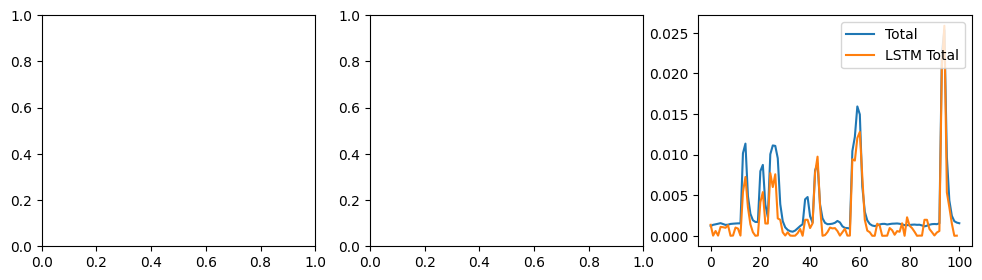

Bucket 1
NSE Total:  0.8056660903909554
RMSE Total:  0.0022449420696020665
MAE Total:  0.0009656381880213425
Mass into the system:  58.4522748698669
Mass out or left over: 24.63864012564244
Percent mass residual: 58%


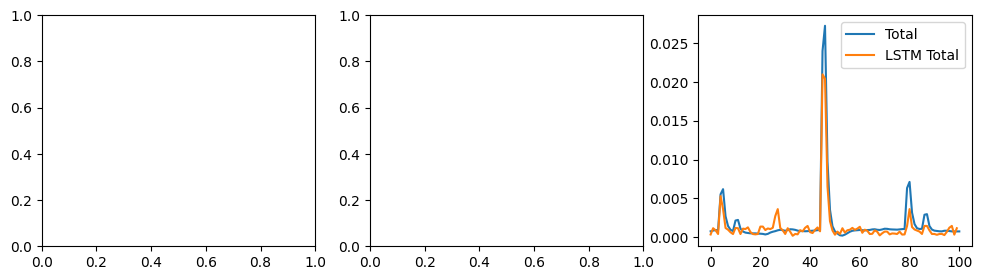

*** Network Metrics ***
Network 400
NSE Total:  0.7913196511944012
RMSE Total:  0.0021724772418910267
MAE Total:  0.0011484905718338414
Mass into the system:  120.39160874746023
Mass out or left over:  54.97556911570181
Percent mass residual: 54%
*** Network 401 ***
Bucket 0
NSE Total:  0.703231222664189
RMSE Total:  0.0020782172405818832
MAE Total:  0.0012401237810999884
Mass into the system:  62.203576354506765
Mass out or left over: 25.09788724568431
Percent mass residual: 60%


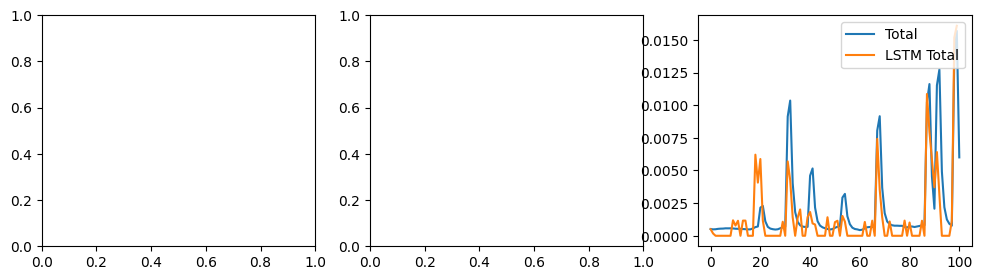

Bucket 1
NSE Total:  0.7183435124922626
RMSE Total:  0.0024554669124590206
MAE Total:  0.0015244058710983212
Mass into the system:  49.935787045536976
Mass out or left over: 33.88808903406015
Percent mass residual: 32%


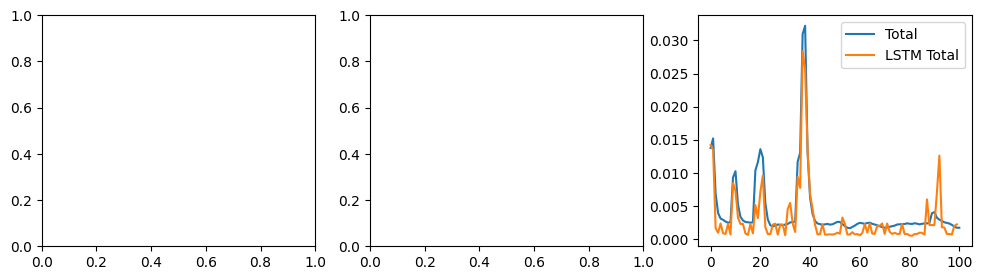

*** Network Metrics ***
Network 401
NSE Total:  0.7107873675782258
RMSE Total:  0.002266842076520452
MAE Total:  0.0013822648260991548
Mass into the system:  112.13936340004375
Mass out or left over:  58.98597627974446
Percent mass residual: 47%
*** Network 402 ***
Bucket 0
NSE Total:  0.8308241129816141
RMSE Total:  0.0019174085627207988
MAE Total:  0.0010438041645348102
Mass into the system:  57.51581116969379
Mass out or left over: 22.86998889564563
Percent mass residual: 60%


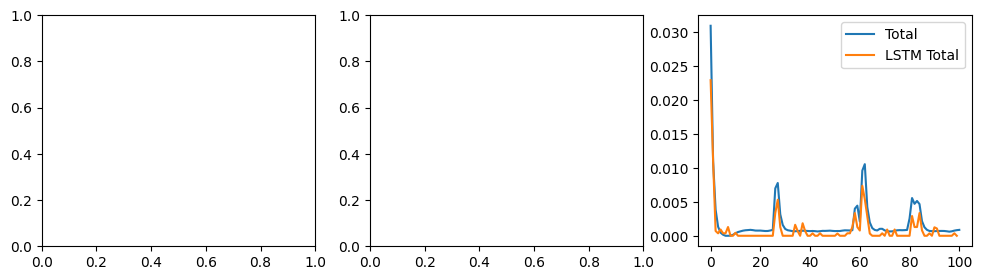

Bucket 1
NSE Total:  0.8593386934995934
RMSE Total:  0.0018444646054875963
MAE Total:  0.0010077745944239117
Mass into the system:  65.90851438435178
Mass out or left over: 24.67737888406078
Percent mass residual: 63%


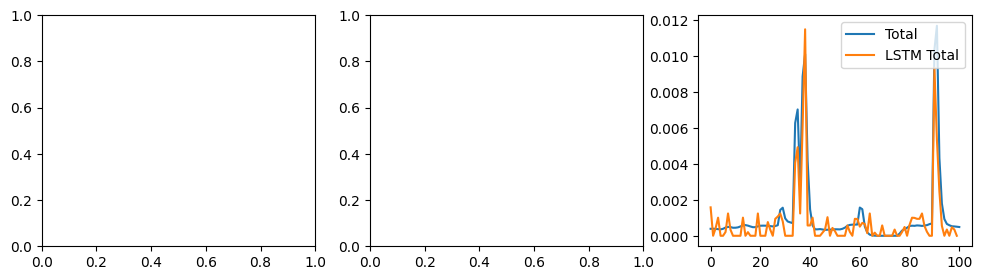

*** Network Metrics ***
Network 402
NSE Total:  0.8450814032406038
RMSE Total:  0.0018809365841041975
MAE Total:  0.001025789379479361
Mass into the system:  123.42432555404557
Mass out or left over:  47.547367779706406
Percent mass residual: 61%
*** Network 403 ***
Bucket 0
NSE Total:  0.863567636037392
RMSE Total:  0.0020596516157824858
MAE Total:  0.0009292778112536749
Mass into the system:  62.98769399222029
Mass out or left over: 27.087739818658427
Percent mass residual: 57%


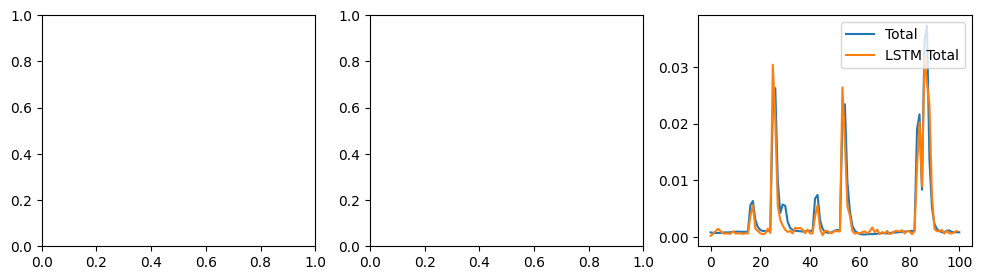

Bucket 1
NSE Total:  0.8506728239383906
RMSE Total:  0.001923933823341231
MAE Total:  0.0008298141537694811
Mass into the system:  61.77984066810012
Mass out or left over: 28.240380009458644
Percent mass residual: 54%


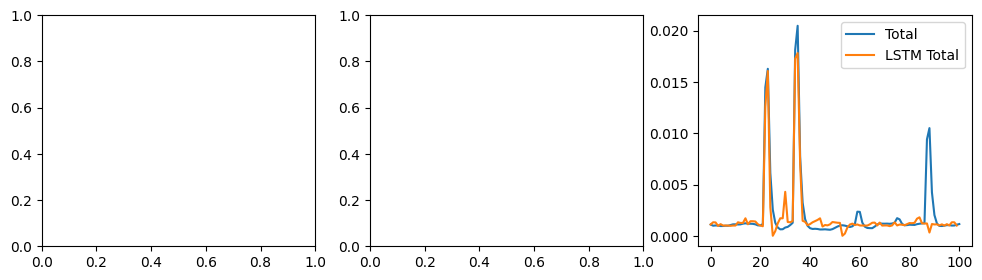

*** Network Metrics ***
Network 403
NSE Total:  0.8571202299878913
RMSE Total:  0.0019917927195618585
MAE Total:  0.000879545982511578
Mass into the system:  124.76753466032041
Mass out or left over:  55.32811982811707
Percent mass residual: 56%
*** Network 404 ***
Bucket 0
NSE Total:  0.8293092776150687
RMSE Total:  0.001992449042185074
MAE Total:  0.0011153436233739566
Mass into the system:  49.52581711670289
Mass out or left over: 20.03343182717207
Percent mass residual: 60%


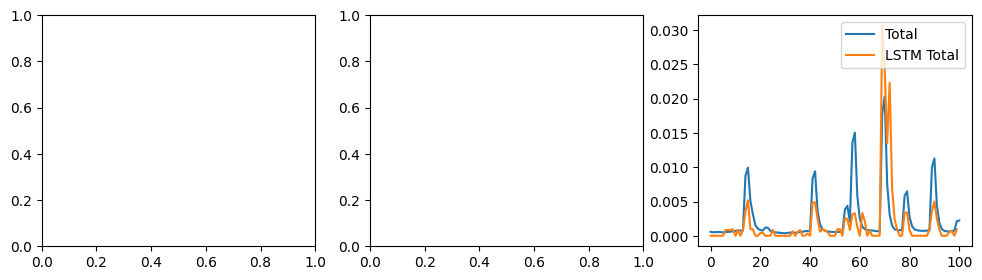

Bucket 1
NSE Total:  0.820885783911668
RMSE Total:  0.0023945413498623874
MAE Total:  0.0009877664961114032
Mass into the system:  60.414828930476176
Mass out or left over: 21.496514933100975
Percent mass residual: 64%


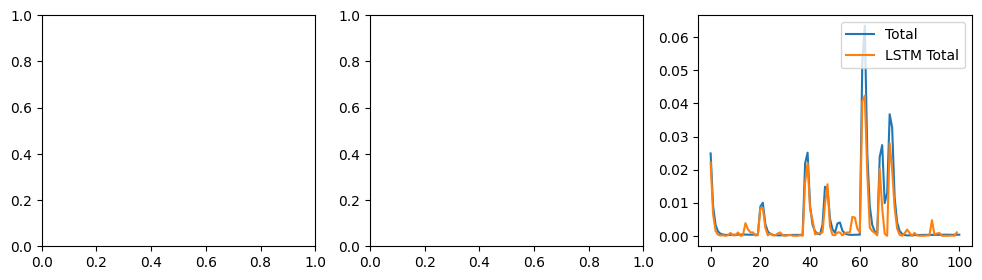

*** Network Metrics ***
Network 404
NSE Total:  0.8250975307633683
RMSE Total:  0.0021934951960237304
MAE Total:  0.00105155505974268
Mass into the system:  109.94064604717906
Mass out or left over:  41.52994676027305
Percent mass residual: 62%
*** Network 405 ***
Bucket 0
NSE Total:  0.8082668706902308
RMSE Total:  0.0019150971184303982
MAE Total:  0.0010641025538644649
Mass into the system:  47.68145385971272
Mass out or left over: 21.10684871836256
Percent mass residual: 56%


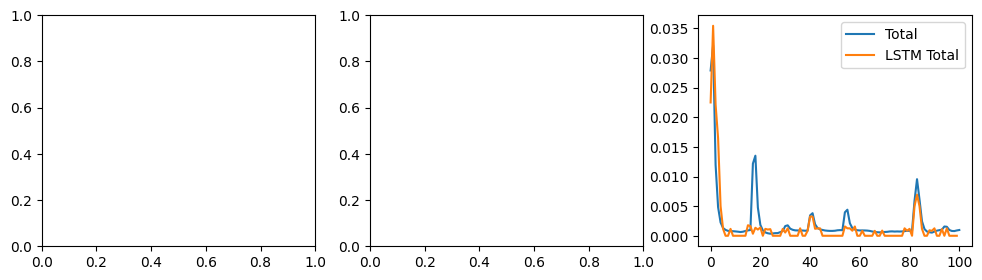

Bucket 1
NSE Total:  0.8379344479130435
RMSE Total:  0.0018845798663301118
MAE Total:  0.0009930911168514122
Mass into the system:  66.20939890177563
Mass out or left over: 31.664995089084893
Percent mass residual: 52%


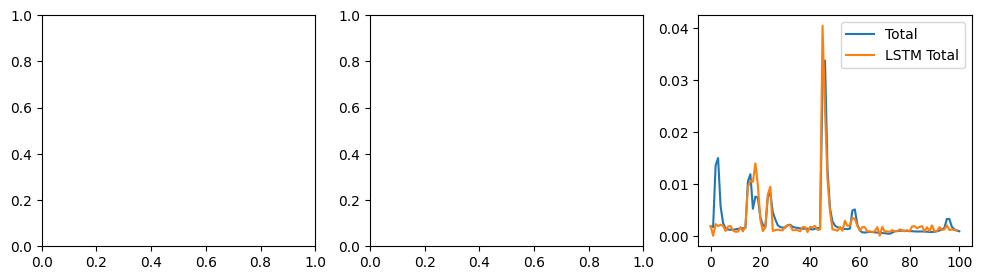

*** Network Metrics ***
Network 405
NSE Total:  0.8231006593016372
RMSE Total:  0.001899838492380255
MAE Total:  0.0010285968353579385
Mass into the system:  113.89085276148835
Mass out or left over:  52.77184380744745
Percent mass residual: 54%
*** Network 406 ***
Bucket 0
NSE Total:  0.6692452261123762
RMSE Total:  0.001906931656626846
MAE Total:  0.0010856749299294867
Mass into the system:  46.062002485701946
Mass out or left over: 18.14985509310207
Percent mass residual: 61%


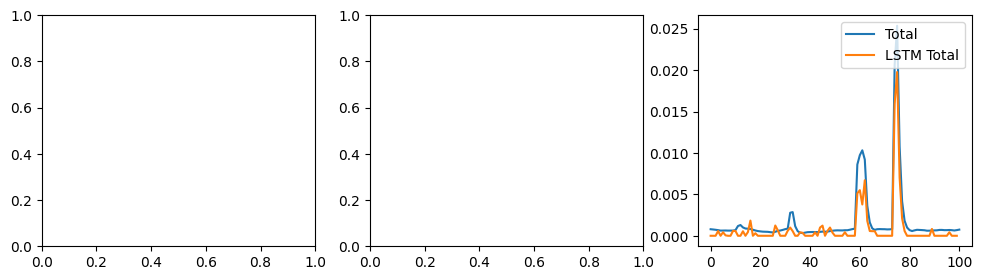

Bucket 1
NSE Total:  0.8247800767749478
RMSE Total:  0.002057085871959322
MAE Total:  0.001013263994694882
Mass into the system:  49.00725631439974
Mass out or left over: 18.541254735306005
Percent mass residual: 62%


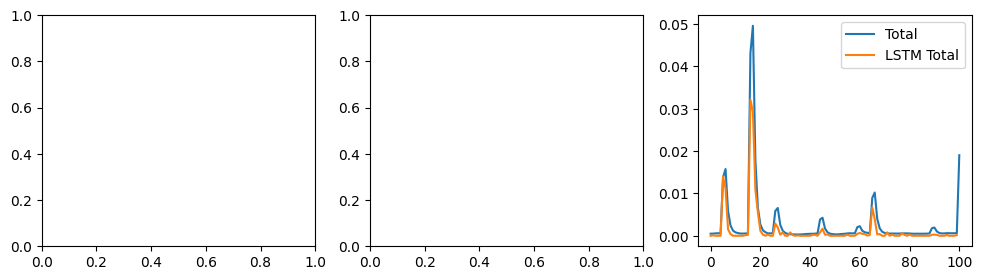

*** Network Metrics ***
Network 406
NSE Total:  0.747012651443662
RMSE Total:  0.001982008764293084
MAE Total:  0.0010494694623121843
Mass into the system:  95.0692588001017
Mass out or left over:  36.691109828408074
Percent mass residual: 61%
*** Network 407 ***
Bucket 0
NSE Total:  0.8572964986172572
RMSE Total:  0.0020986784328575017
MAE Total:  0.0010403640683617165
Mass into the system:  61.867381864236606
Mass out or left over: 22.077327975981135
Percent mass residual: 64%


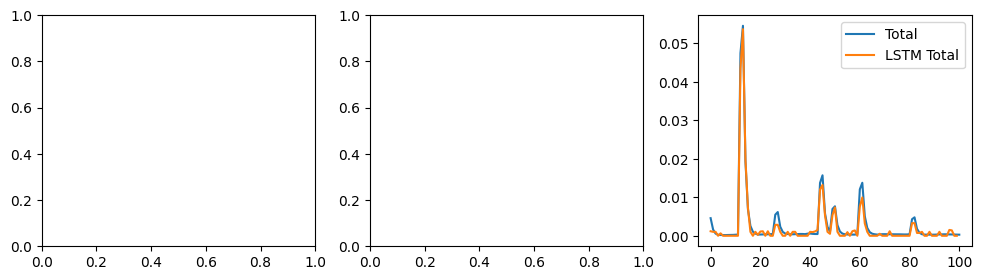

Bucket 1
NSE Total:  0.8581071628966694
RMSE Total:  0.0028077755049578618
MAE Total:  0.0011232139667026264
Mass into the system:  67.4170218586246
Mass out or left over: 24.35436164718762
Percent mass residual: 64%


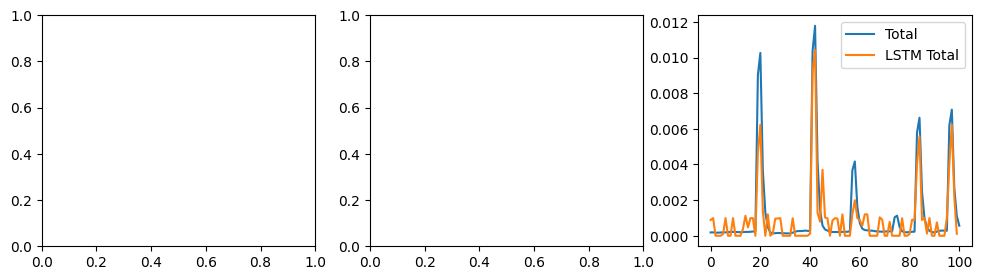

*** Network Metrics ***
Network 407
NSE Total:  0.8577018307569633
RMSE Total:  0.0024532269689076817
MAE Total:  0.0010817890175321716
Mass into the system:  129.2844037228612
Mass out or left over:  46.43168962316875
Percent mass residual: 64%
*** Network 408 ***
Bucket 0
NSE Total:  0.7765109706193253
RMSE Total:  0.0020876118438799616
MAE Total:  0.0011931659887756707
Mass into the system:  62.327199958386146
Mass out or left over: 29.287057761775127
Percent mass residual: 53%


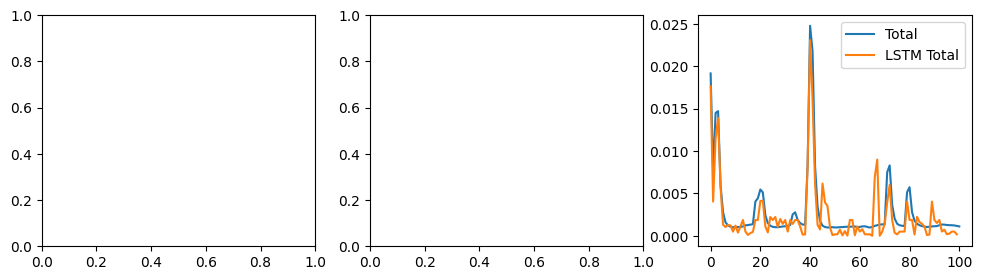

Bucket 1
NSE Total:  0.857718554377285
RMSE Total:  0.0020878090368372333
MAE Total:  0.0010860218193446084
Mass into the system:  55.776820021052075
Mass out or left over: 22.26515767681834
Percent mass residual: 60%


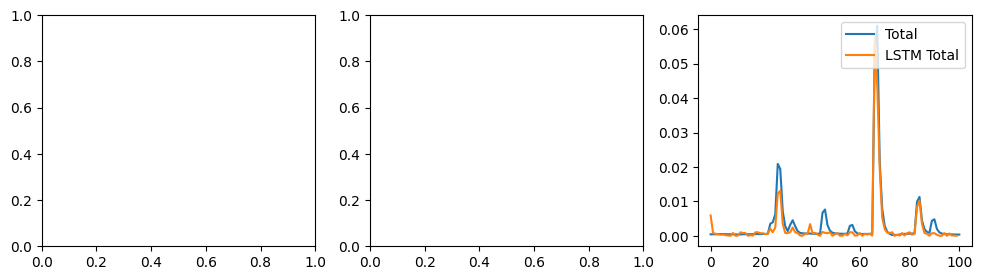

*** Network Metrics ***
Network 408
NSE Total:  0.8171147624983051
RMSE Total:  0.0020877104403585972
MAE Total:  0.0011395939040601396
Mass into the system:  118.10401997943822
Mass out or left over:  51.552215438593464
Percent mass residual: 56%
*** Network 409 ***
Bucket 0
NSE Total:  0.7461697891920498
RMSE Total:  0.0020501477413522994
MAE Total:  0.0011603769957554391
Mass into the system:  48.455230730127674
Mass out or left over: 19.402550764076594
Percent mass residual: 60%


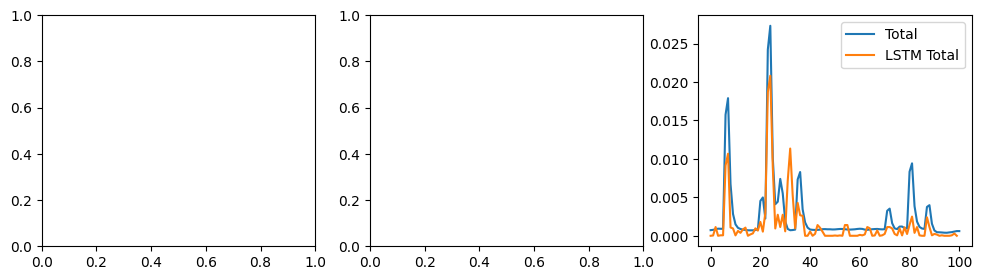

Bucket 1
NSE Total:  0.8847215975421541
RMSE Total:  0.001926840441820757
MAE Total:  0.0009718390352357676
Mass into the system:  68.4846742788335
Mass out or left over: 25.416569118954037
Percent mass residual: 63%


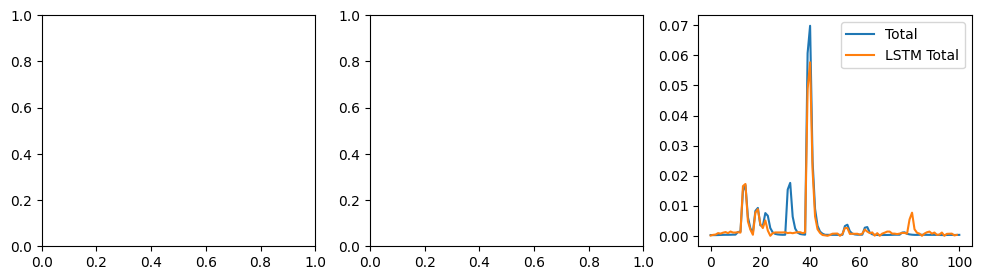

*** Network Metrics ***
Network 409
NSE Total:  0.8154456933671019
RMSE Total:  0.0019884940915865282
MAE Total:  0.0010661080154956034
Mass into the system:  116.93990500896118
Mass out or left over:  44.81911988303063
Percent mass residual: 62%
*** Network 410 ***
Bucket 0
NSE Total:  0.7331430741712178
RMSE Total:  0.001984738029949845
MAE Total:  0.0013898242752188859
Mass into the system:  49.519207153060755
Mass out or left over: 29.584645899718886
Percent mass residual: 40%


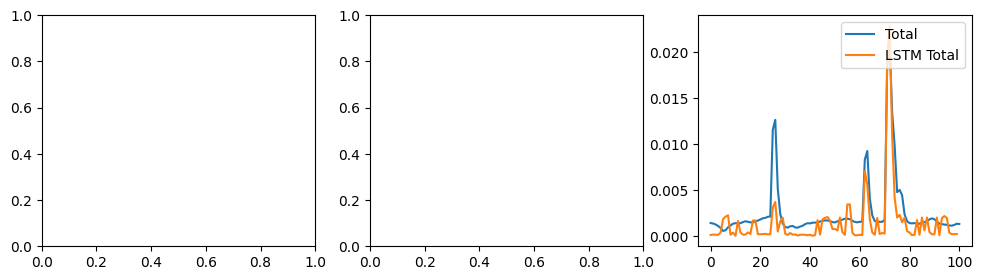

Bucket 1
NSE Total:  0.8034752195169584
RMSE Total:  0.0029916641744436225
MAE Total:  0.0015836738694629238
Mass into the system:  65.67786556798117
Mass out or left over: 29.31475308293502
Percent mass residual: 55%


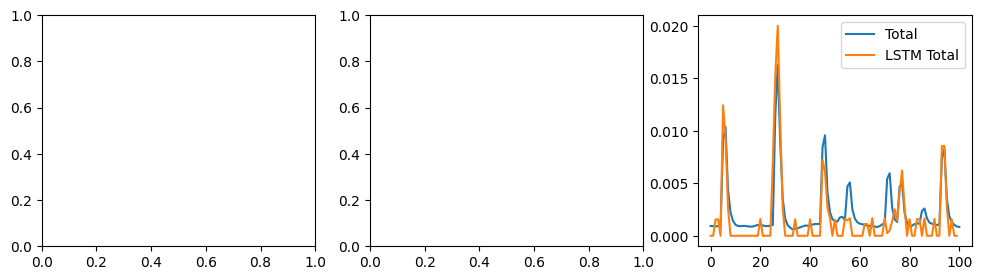

*** Network Metrics ***
Network 410
NSE Total:  0.7683091468440881
RMSE Total:  0.0024882011021967335
MAE Total:  0.0014867490723409049
Mass into the system:  115.19707272104193
Mass out or left over:  58.899398982653906
Percent mass residual: 49%
*** Network 411 ***
Bucket 0
NSE Total:  0.8224637517288409
RMSE Total:  0.00210625269124097
MAE Total:  0.00106973635413293
Mass into the system:  61.23111332283579
Mass out or left over: 31.996476400474627
Percent mass residual: 48%


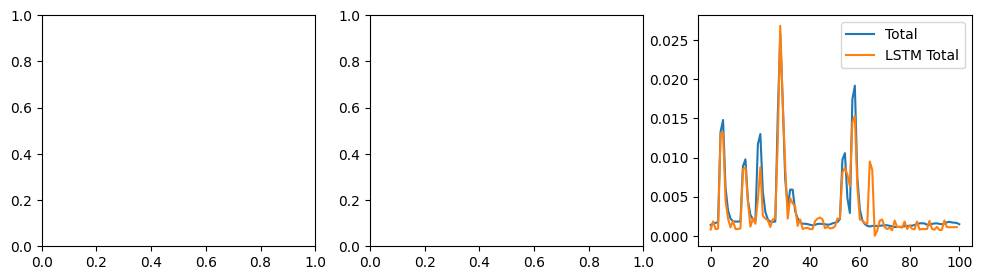

Bucket 1
NSE Total:  0.7772370491623956
RMSE Total:  0.0019299129294479895
MAE Total:  0.0008687323428438014
Mass into the system:  51.84614363864878
Mass out or left over: 27.15930931141004
Percent mass residual: 48%


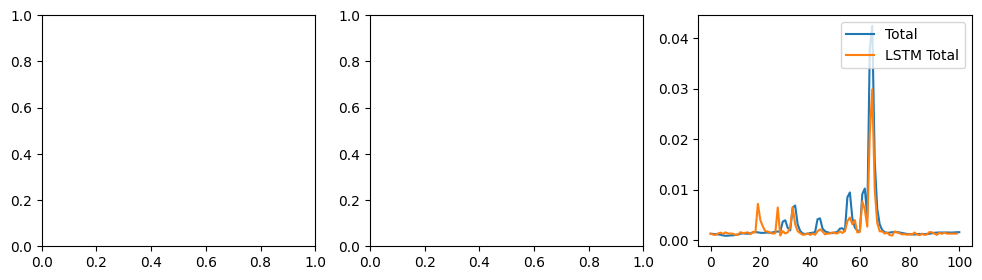

*** Network Metrics ***
Network 411
NSE Total:  0.7998504004456182
RMSE Total:  0.00201808281034448
MAE Total:  0.0009692343484883657
Mass into the system:  113.07725696148458
Mass out or left over:  59.15578571188467
Percent mass residual: 48%
*** Network 412 ***
Bucket 0
NSE Total:  0.8200952798604408
RMSE Total:  0.0017820839057863737
MAE Total:  0.0009953989008712613
Mass into the system:  57.43000308477758
Mass out or left over: 19.345645012064097
Percent mass residual: 66%


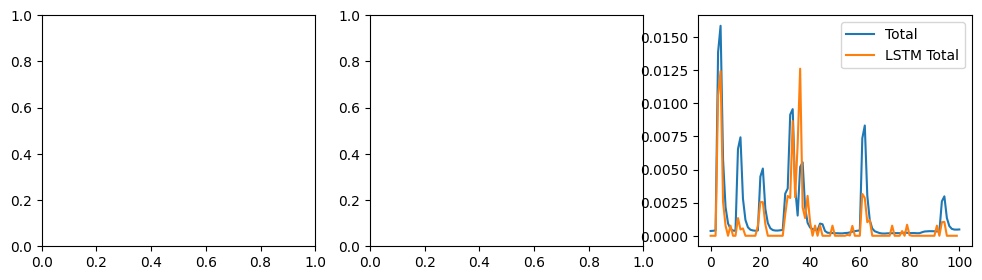

Bucket 1
NSE Total:  0.746912792562655
RMSE Total:  0.0018119884611241012
MAE Total:  0.0008448865362297396
Mass into the system:  52.96591881220174
Mass out or left over: 19.042899894939527
Percent mass residual: 64%


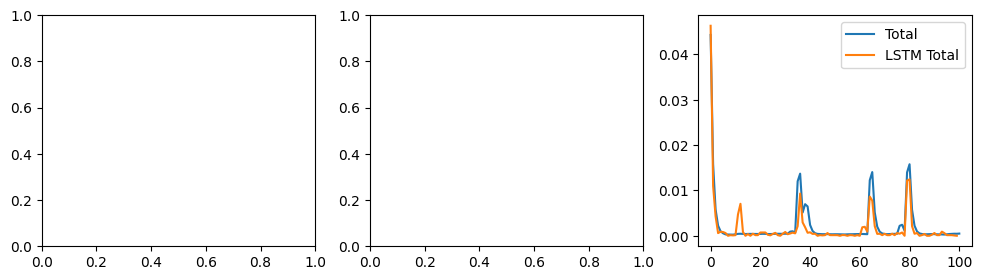

*** Network Metrics ***
Network 412
NSE Total:  0.783504036211548
RMSE Total:  0.0017970361834552374
MAE Total:  0.0009201427185505004
Mass into the system:  110.39592189697933
Mass out or left over:  38.38854490700362
Percent mass residual: 65%
*** Network 413 ***
Bucket 0
NSE Total:  0.8120254676067099
RMSE Total:  0.002216371208777817
MAE Total:  0.0011749637841564392
Mass into the system:  55.37909985229514
Mass out or left over: 27.40860634316611
Percent mass residual: 51%


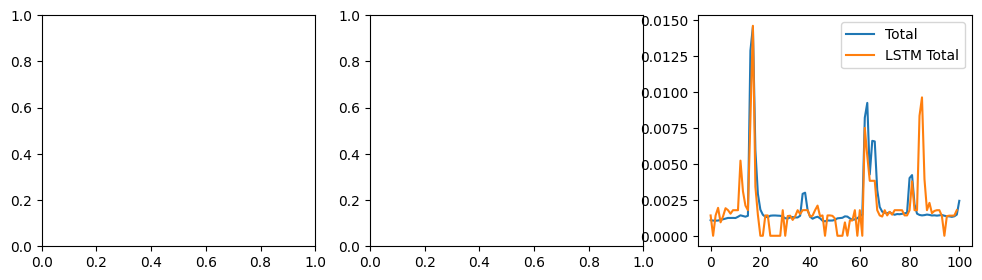

Bucket 1
NSE Total:  0.7503376103191038
RMSE Total:  0.002211148949944478
MAE Total:  0.0009424379525441304
Mass into the system:  58.85041259858495
Mass out or left over: 34.41971814254687
Percent mass residual: 42%


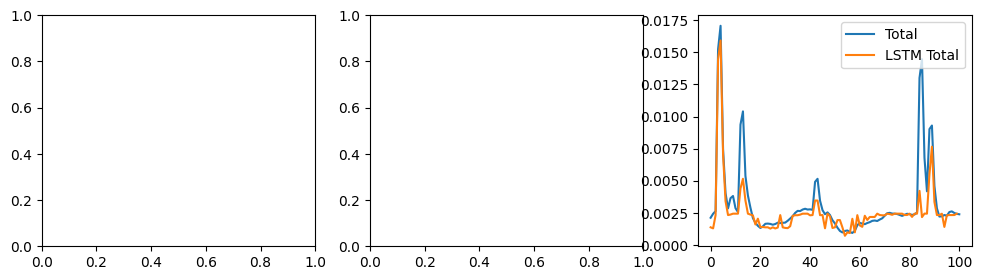

*** Network Metrics ***
Network 413
NSE Total:  0.7811815389629069
RMSE Total:  0.0022137600793611474
MAE Total:  0.0010587008683502848
Mass into the system:  114.2295124508801
Mass out or left over:  61.82832448571298
Percent mass residual: 46%
*** Network 414 ***
Bucket 0
NSE Total:  0.6235896492424755
RMSE Total:  0.002061876324987927
MAE Total:  0.0010179905623520682
Mass into the system:  47.0731003280853
Mass out or left over: 18.67806074991588
Percent mass residual: 60%


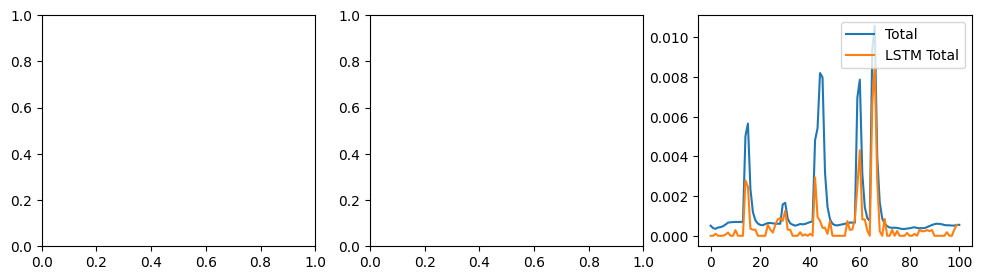

Bucket 1
NSE Total:  0.6970280922245718
RMSE Total:  0.00245590933394969
MAE Total:  0.0010186216534525967
Mass into the system:  55.287001073289964
Mass out or left over: 22.189514902567215
Percent mass residual: 60%


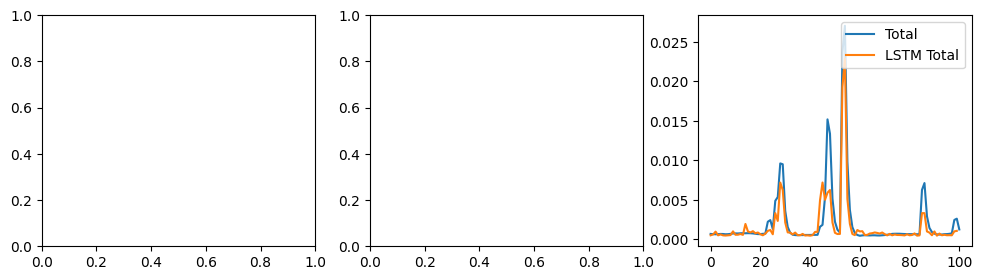

*** Network Metrics ***
Network 414
NSE Total:  0.6603088707335236
RMSE Total:  0.0022588928294688085
MAE Total:  0.0010183061079023325
Mass into the system:  102.36010140137526
Mass out or left over:  40.8675756524831
Percent mass residual: 60%
*** Network 415 ***
Bucket 0
NSE Total:  0.8995119054843043
RMSE Total:  0.0023004796261879017
MAE Total:  0.0011696729612027921
Mass into the system:  63.16219482350088
Mass out or left over: 30.080926264385017
Percent mass residual: 52%


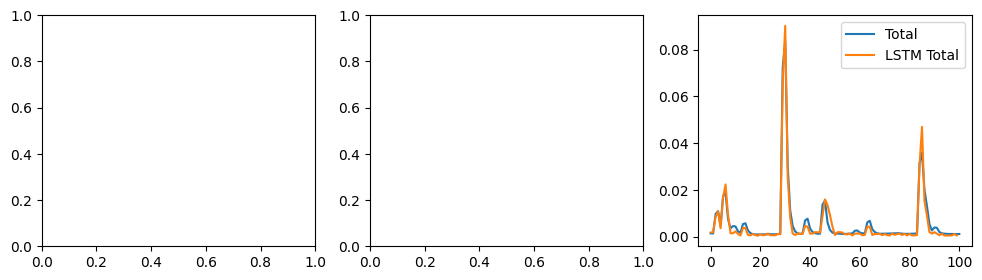

Bucket 1
NSE Total:  0.7403312391342335
RMSE Total:  0.0021994088472955865
MAE Total:  0.0010811330240968794
Mass into the system:  51.02966754969769
Mass out or left over: 22.083947552881106
Percent mass residual: 57%


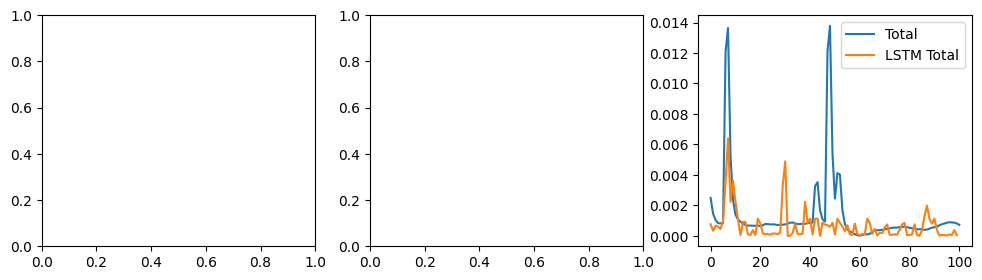

*** Network Metrics ***
Network 415
NSE Total:  0.8199215723092689
RMSE Total:  0.002249944236741744
MAE Total:  0.0011254029926498358
Mass into the system:  114.19186237319857
Mass out or left over:  52.16487381726613
Percent mass residual: 54%
*** Network 416 ***
Bucket 0
NSE Total:  0.8804944627139186
RMSE Total:  0.0022253346638547015
MAE Total:  0.0012332553957419459
Mass into the system:  61.31998408151571
Mass out or left over: 31.56885116998703
Percent mass residual: 49%


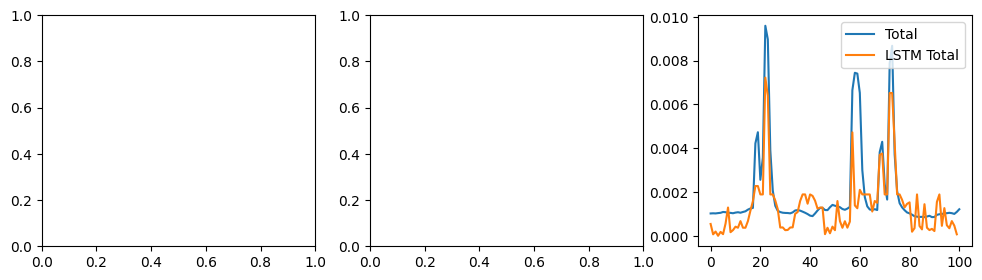

Bucket 1
NSE Total:  0.7882484145882473
RMSE Total:  0.002096005694962534
MAE Total:  0.0009935531453164766
Mass into the system:  63.66872413816615
Mass out or left over: 38.77921491387893
Percent mass residual: 39%


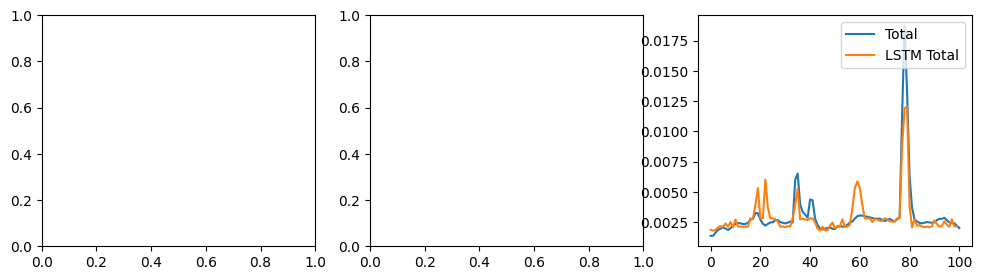

*** Network Metrics ***
Network 416
NSE Total:  0.834371438651083
RMSE Total:  0.0021606701794086177
MAE Total:  0.0011134042705292111
Mass into the system:  124.98870821968185
Mass out or left over:  70.34806608386596
Percent mass residual: 44%
*** Network 417 ***
Bucket 0
NSE Total:  0.5899599166634317
RMSE Total:  0.004022908529674189
MAE Total:  0.0029297396289329736
Mass into the system:  58.442005995802695
Mass out or left over: 41.13023160354161
Percent mass residual: 30%


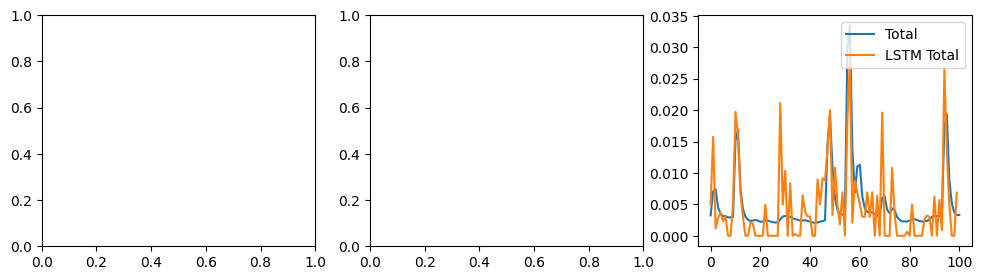

Bucket 1
NSE Total:  0.7106799286055414
RMSE Total:  0.0021937589515272555
MAE Total:  0.0010210787117653562
Mass into the system:  51.19189773854538
Mass out or left over: 18.929718880038347
Percent mass residual: 63%


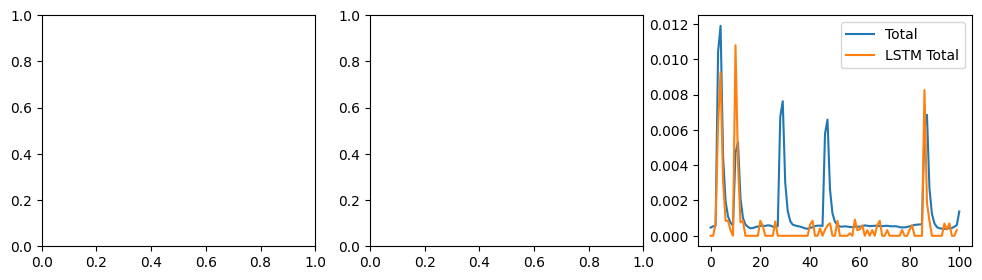

*** Network Metrics ***
Network 417
NSE Total:  0.6503199226344866
RMSE Total:  0.003108333740600722
MAE Total:  0.001975409170349165
Mass into the system:  109.63390373434808
Mass out or left over:  60.059950483579954
Percent mass residual: 45%
*** Network 418 ***
Bucket 0
NSE Total:  0.4900461113553508
RMSE Total:  0.0027557639765872053
MAE Total:  0.0019500468395917464
Mass into the system:  51.621268018465685
Mass out or left over: 34.68154547452623
Percent mass residual: 33%


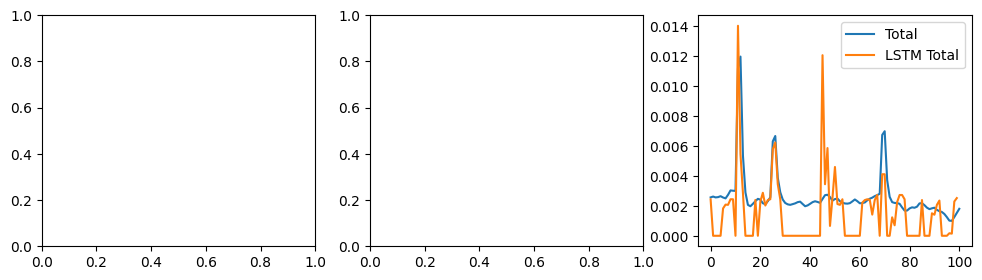

Bucket 1
NSE Total:  0.7913915458608745
RMSE Total:  0.002865687619253566
MAE Total:  0.0014411510551334832
Mass into the system:  65.80064913360278
Mass out or left over: 28.114346005201895
Percent mass residual: 57%


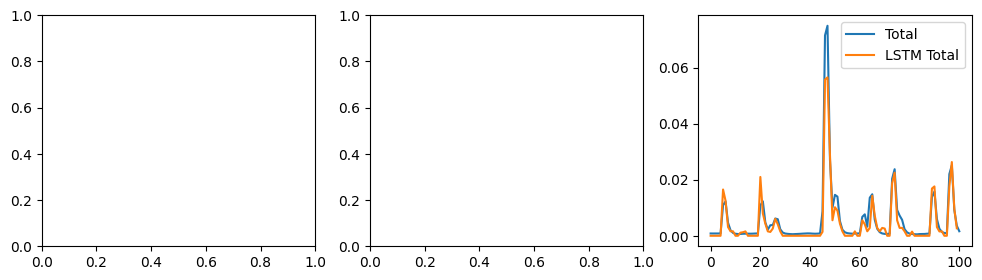

*** Network Metrics ***
Network 418
NSE Total:  0.6407188286081127
RMSE Total:  0.0028107257979203856
MAE Total:  0.0016955989473626148
Mass into the system:  117.42191715206846
Mass out or left over:  62.79589147972813
Percent mass residual: 47%
*** Network 419 ***
Bucket 0
NSE Total:  0.8076158972384615
RMSE Total:  0.0023743808698953464
MAE Total:  0.0014541995743338663
Mass into the system:  61.72629358049976
Mass out or left over: 28.30989778965878
Percent mass residual: 54%


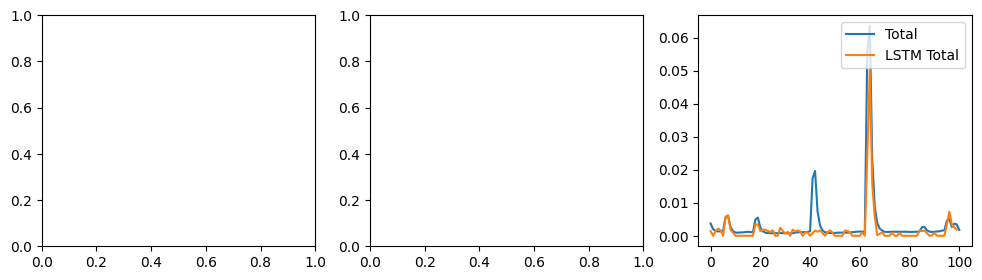

Bucket 1
NSE Total:  0.867775805738658
RMSE Total:  0.0024114938297826426
MAE Total:  0.0010631328418443035
Mass into the system:  60.71646925774434
Mass out or left over: 20.94790561385114
Percent mass residual: 65%


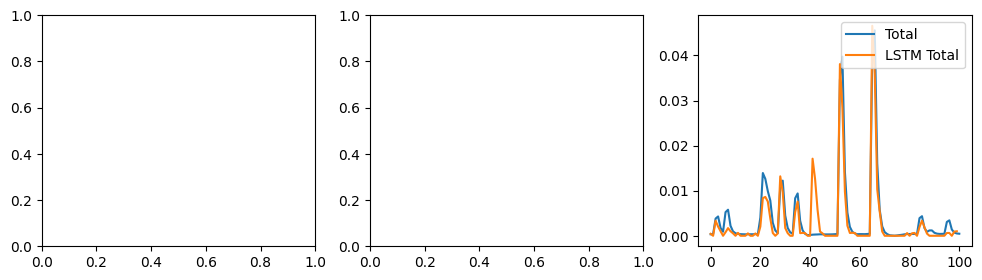

*** Network Metrics ***
Network 419
NSE Total:  0.8376958514885597
RMSE Total:  0.0023929373498389945
MAE Total:  0.0012586662080890849
Mass into the system:  122.44276283824411
Mass out or left over:  49.257803403509925
Percent mass residual: 60%


In [129]:
## For combined bucket network inputs with combined downstream flow data
test_model_combined_metrics_list = []
for inetwork in basin_networks_test:
    network_metrics_df = check_test_period_combined(lstm_combined, combined_np_test_seq_X, inetwork, n_plot=100, verbose=True)
    test_model_combined_metrics_list.append(network_metrics_df.iloc[0].to_dict())

In [127]:
## For combined bucket network inputs with combined downstream flow data
print_model_metrics(test_model_combined_metrics_list, "Testing: Combined bucket network inputs with combined downstream flow data")

*** Model Metrics - Testing: Combined bucket network inputs with combined downstream flow data ***
Average NSE Total:  0.7795390663309261
Average RMSE Total:  0.002249543908526131
Average MAE Total:  0.0011742780372323127


In [128]:
print("End")

End
